In [11]:
# Setup
import sys
import numpy as np
import tensorflow as tf
import Utils.PokemonUtils as pkmnUtils
from matplotlib import pyplot as plt
import importlib

utils = pkmnUtils.PokemonUtils(rel_loc="")

# Only run if split file has not already been generated
if False:
    utils.loadAllGIFs()
    
utils.localLoadAllGifs("Data/SplitsV2.npz")
x_train, x_val, x_test, y_train, y_val, y_test = utils.getSplits()

# TRANSFER LEARNING ONLY: Don't use transparency channel
x_train_m = x_train[:,:,:,0:3].astype('float32') 
x_val_m = x_val[:,:,:,0:3].astype('float32') 
x_test_m = x_test[:,:,:,0:3].astype('float32')
y_train_m = y_train
y_val_m = y_val
y_test_m = y_test

# Images (range 0-1 necessary for imshow)
x_train_i = (x_train_m) / 255
x_val_i   = (x_val_m)   / 255
x_test_i  = (x_test_m)  / 255

# Model
x_mean = np.mean(x_train_m)
x_train_m = (x_train_m - x_mean) / 255
x_val_m   = (x_val_m - x_mean)   / 255
x_test_m  = (x_test_m - x_mean)  / 255

# Small (1 frame per pokemon)
x_train_s = x_train_m[::10]
x_val_s   = x_val_m[::10]
x_test_s  = x_test_m[::10]
y_train_s = y_train_m[::10]
y_val_s   = y_val_m[::10]
y_test_s  = y_test_m[::10]

# Downsampled (5 frames per pokemon, 64x64)
x_train_d = x_train_m[::2,::2,::2,:]
x_val_d   = x_val_m[::2,::2,::2,:]
x_test_d  = x_test_m[::2,::2,::2,:]
y_train_d = y_train_m[::2]
y_val_d   = y_val_m[::2]
y_test_d  = y_test_m[::2]

print("Data normalization:")
print("mean:", x_mean)
print("max: ", np.max(x_train_m))
print("min: ", np.min(x_train_m))
print("Data shapes:")
print("x_train_m:", x_train_m.shape)
print("x_val_m:  ", x_val_m.shape)
print("x_test_m: ", x_test_m.shape)
print("y_train_m:", y_train_m.shape)
print("y_val_m:  ", y_val_m.shape)
print("y_test_m: ", y_test_m.shape)
print("x_train_s:", x_train_s.shape)
print("x_val_s:  ", x_val_s.shape)
print("x_test_s: ", x_test_s.shape)
print("y_train_s:", y_train_s.shape)
print("y_val_s:  ", y_val_s.shape)
print("y_test_s: ", y_test_s.shape)
print("x_train_d:", x_train_d.shape)
print("x_val_d:  ", x_val_d.shape)
print("x_test_d: ", x_test_d.shape)
print("y_train_d:", y_train_d.shape)
print("y_val_d:  ", y_val_d.shape)
print("y_test_d: ", y_test_d.shape)

x_train: (6010, 128, 128, 4)
x_val:   (1510, 128, 128, 4)
x_test:  (1880, 128, 128, 4)
y_train: (6010,)
y_val:   (1510,)
y_test:  (1880,)
Data normalization:
mean: 22.080812
max:  0.9134086
min:  -0.08659142
Data shapes:
x_train_m: (6010, 128, 128, 3)
x_val_m:   (1510, 128, 128, 3)
x_test_m:  (1880, 128, 128, 3)
y_train_m: (6010,)
y_val_m:   (1510,)
y_test_m:  (1880,)
x_train_s: (601, 128, 128, 3)
x_val_s:   (151, 128, 128, 3)
x_test_s:  (188, 128, 128, 3)
y_train_s: (601,)
y_val_s:   (151,)
y_test_s:  (188,)
x_train_d: (3005, 64, 64, 3)
x_val_d:   (755, 64, 64, 3)
x_test_d:  (940, 64, 64, 3)
y_train_d: (3005,)
y_val_d:   (755,)
y_test_d:  (940,)


Code in this notebook inspired by: https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

In [7]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 128, 128
# train_data_dir = "data/train"
# validation_data_dir = "data/val"
# nb_train_samples = 6010
# nb_validation_samples = 1510 
# batch_size = 64
# epochs = 30

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [20]:
# Freeze the layers which you don't want to train. Here I am freezing the first 5 layers.
for layer in model.layers[:5]:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(18, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import skimage.color as color

def oneHot(y, cols=None):
    if (cols < 1):
        cols = np.max(y)
    n = y.shape[0]
    z = np.zeros((n, cols))
    z[np.arange(n), (y-1)] = 1
    return z


data_aug = ImageDataGenerator(
    rotation_range=50,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [23]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

# Train the model 
history = model_final.fit_generator(
    data_aug.flow(x_train_s, oneHot(y_train_s, 18), batch_size=64),
    epochs=1,
    verbose=1,
    validation_data=(x_val_s, oneHot(y_val_s, 18)),
    callbacks = [checkpoint, early]
)

Epoch 1/1
10/10 [==============================] - 179s 18s/step - loss: 14.7950 - acc: 0.0821 - val_loss: 15.5844 - val_acc: 0.0331

Epoch 00001: val_acc improved from -inf to 0.03311, saving model to vgg16_1.h5


In [25]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# from keras.models import Sequential
# from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
# from keras import regularizers
from keras.layers import Input


img_width, img_height = 128, 128

### Build the network 
img_input = Input(shape=(128, 128, 3))
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

model = Model(inputs = img_input, outputs = x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
Total para

In [26]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
print([layer.name for layer in model.layers])

import h5py
weights_path = 'Models/vgg19_weights.h5'  # (https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5)
# f = h5py.File(weights_path)
# print(f)

# print(list(f["model_weights"].keys()))

# list all the layer names which are in the model.
layer_names = [layer.name for layer in model.layers]

model.load_weights(weights_path, by_name=True)
layer_count=0;
w = []
for layer in model.layers:
    weights = layer.get_weights()
    w.append(weights)
    layer_count=layer_count+1
    print("[INFO] Model Layer Configuration with respect to each layer weights as follows : " + str(layer.get_config()), str(layer.name),str(weights))
print("[INFO] The total number layers is : " + str(layer_count))
layer_names.index("block1_conv1")
for i in layer_dict.keys():
    index = layer_names.index(i)
    model.layers[index].set_weights(w[index])


['input_5', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool']
[INFO] Model Layer Configuration with respect to each layer weights as follows : {'batch_input_shape': (None, 128, 128, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_5'} input_5 []
[INFO] Model Layer Configuration with respect to each layer weights as follows : {'name': 'block1_conv1', 'trainable': True, 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None} block1_conv1 [array([[[[ 0.09016377,  0.02015451,  0.08175632, ...,

In [47]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import glob

def extractFeatures(x):
    features = np.empty((len(x), 32, 32, 128))
    for i in range(len(x)):
        if i % 100 == 0:
            print(i)
        im = x[i]
        im = np.expand_dims(im, axis=0)
        outcome = model.predict(im)
        features[i] = outcome[0]
    return features
    
# Extract features
x_train_feats = extractFeatures(x_train_m)
print("Done!")
x_val_feats = extractFeatures(x_val_m)
print("Done!")
x_test_feats = extractFeatures(x_test_m)
print("Done!")


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
Done!
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
Done!
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
Done!


In [49]:
print("x_train_feats:", x_train_feats.shape)
print("x_val_feats:  ", x_val_feats.shape)
print("x_test_feats: ", x_test_feats.shape)

x_train_feats: (6010, 32, 32, 128)
x_val_feats:   (1510, 32, 32, 128)
x_test_feats:  (1880, 32, 32, 128)


In [52]:
from keras.layers import Activation
from keras import regularizers

# Make model
reg = 0.001
model = Sequential([
        Flatten(input_shape=(32,32,128)),                
        Dense(64, kernel_regularizer=regularizers.l2(reg)),
        Activation("relu"),
        Dense(18, kernel_regularizer=regularizers.l2(reg)),
        Activation("softmax")
])

In [56]:
# Training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

filepath = "./Models/transfer_model_1.hdf5"
batch_size = 64
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(
    data_aug.flow(x_train_feats, oneHot(y_train, 18), batch_size=batch_size),
    epochs=30,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=(x_val_feats, oneHot(y_val, 18)),
)
model.save("./Models/transfer_model_1_final.hdf5")

/home/shared/anaconda3/lib/python3.6/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6010, 32, 32, 128) (128 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/30
94/94 [==============================] - 82s 874ms/step - loss: 2.6659 - acc: 0.1903 - val_loss: 2.8731 - val_acc: 0.1801

Epoch 00001: val_acc improved from -inf to 0.18013, saving model to ./Models/transfer_model_1.hdf5
Epoch 2/30
94/94 [==============================] - 80s 847ms/step - loss: 2.5918 - acc: 0.2123 - val_loss: 2.7830 - val_acc: 0.1709

Epoch 00002: val_acc did not improve
Epoch 3/30
94/94 [==============================] - 79s 843ms/step - loss: 2.5675 - acc: 0.2194 - val_loss: 2.8211 - val_acc: 0.1755

Epoch 00003: val_acc did not improve
Epoch 4/30
94/94 [==============================] - 81s 862ms/step - loss: 2.5659 - acc: 0.2156 - val_loss: 2.7676 - val_acc: 0.1927

Epoch 00004: val_acc improved from 0.18013 to 0.19272, saving model to ./Models/transfer_model_1.hdf5
Epoch 5/30
94/94 [==============================] - 80s 854ms/step - loss: 2.5215 - acc: 0.2449 - val_loss: 2.8194 - val_acc: 0.1649

Epoch 00006: val_acc did not improve
Epoch 7/30
94/94 [

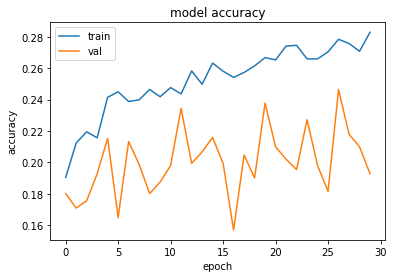

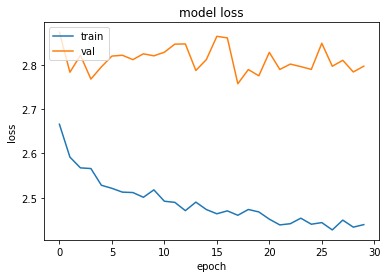

In [57]:
h = history.history

# summarize history for accuracy
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
pred_train_m = model.predict(x_train_feats)
print('Done!')
pred_val_m = model.predict(x_val_feats)
print('Done!')
pred_test_m = model.predict(x_test_feats)
print('Done!')

Done!
Done!
Done!


In [61]:
# Averages scores across frames of pokemon's animation
y_train_2, y_val_2, y_test_2 = utils.getSecondaryTypeLabels()

def customPredict(scores, y, y2=None, frames=10):
    # Averaging
    N, T = scores.shape
    scores_reshaped = scores.reshape((N//10, 10, T))
    avg_scores = np.mean(scores_reshaped, axis=1)
    
    # Primary accuracy
    predictions = np.argmax(avg_scores, axis=1)
    matches = predictions == y-1  # y is 1-indexed
    acc1 = np.sum(matches)/len(matches)
    
    acc2 = None
    if not y2 is None:
        matches2 = predictions == y2-1
        acc2 = np.sum(matches + matches2)/len(matches)  # + acts as an or operator
    
    # Dual accuracy
    return (acc1, acc2, avg_scores)
    

train_acc, train_acc_2, train_avg_scores = customPredict(pred_train_m, y_train_m[::10], y2=y_train_2[::10])
val_acc, val_acc_2, val_avg_scores = customPredict(pred_val_m, y_val_m[::10], y2=y_val_2[::10])
test_acc, test_acc_2, test_avg_scores = customPredict(pred_test_m, y_test_m[::10], y2=y_test_2[::10])
print("Train accuracy primary:       ", train_acc)
print("Train accuracy secondary:     ", train_acc_2)
print("Validation accuracy primary:  ", val_acc)
print("Validation accuracy secondary:", val_acc_2)
print("Test accuracy primary:        ", test_acc)
print("Test accuracy secondary:      ", test_acc_2)

y_train_2: (6010,)
y_val_2:   (1510,)
y_test_2:  (1880,)
Train accuracy primary:        0.2878535773710483
Train accuracy secondary:      0.30948419301164726
Validation accuracy primary:   0.19205298013245034
Validation accuracy secondary: 0.2251655629139073
Test accuracy primary:         0.2553191489361702
Test accuracy secondary:       0.28191489361702127


Train predictions


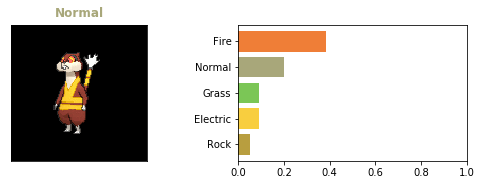

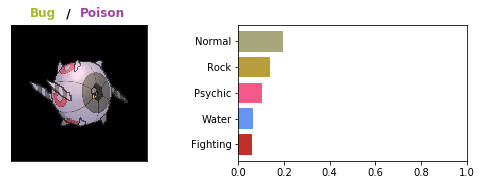

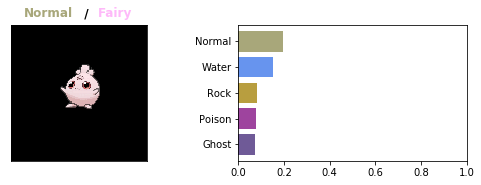

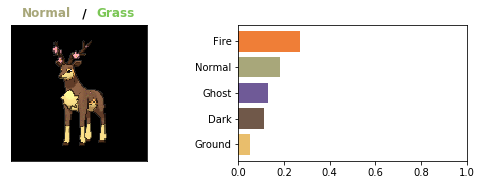

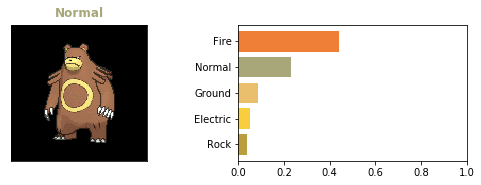

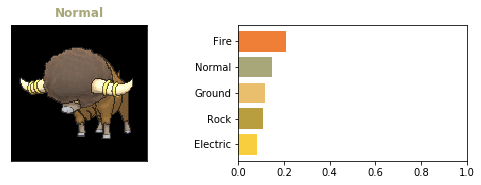

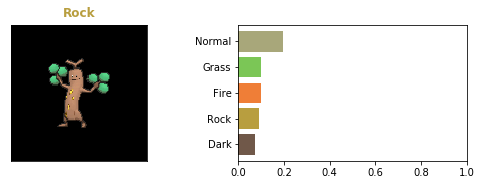

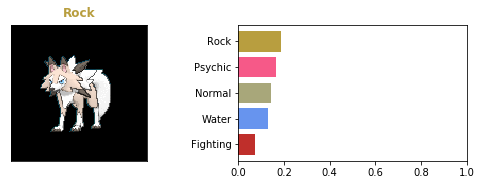

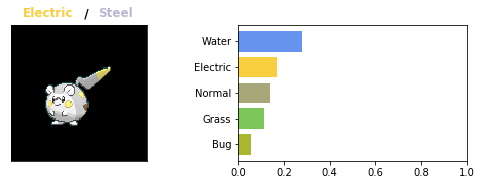

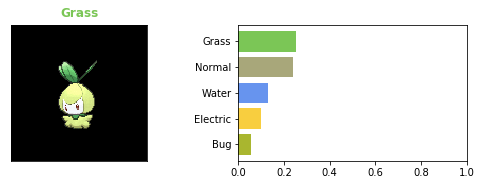

In [65]:
import Utils.PokemonPlot as pp

start = 100  # start index
num = 10    # number of images to display
step = 10  # number of frames / pokemon animation

print("Train predictions")
pp.plotPredictions(x_train_i[start*step:(start+num)*step:step],
                   y_train_m[start*step:(start+num)*step:step],
                   train_avg_scores[start:start+num:1], k=5, y2=y_train_2[start*step:(start+num)*step:step])

Validation predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


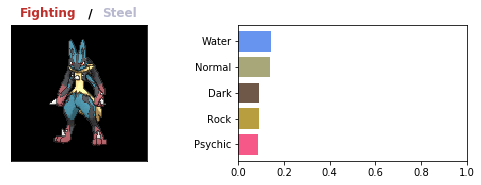

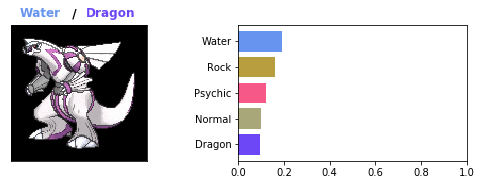

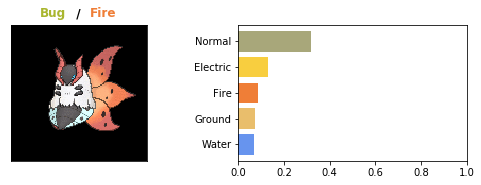

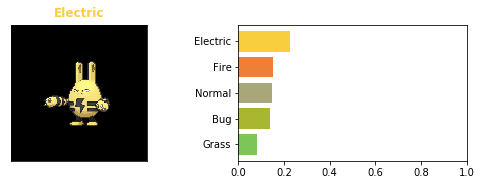

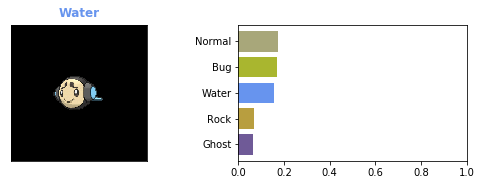

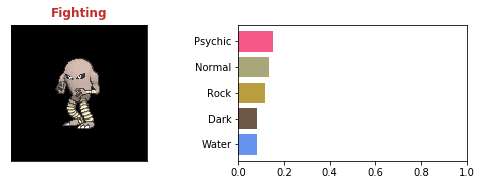

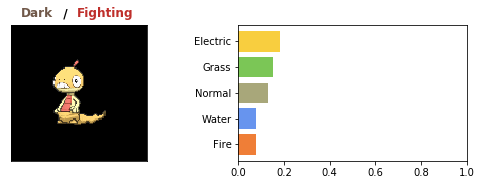

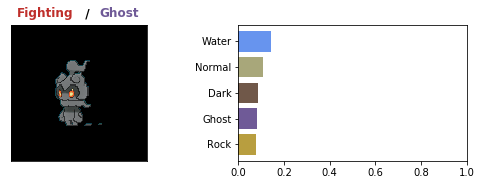

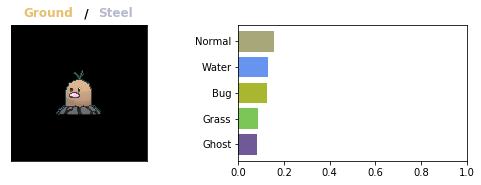

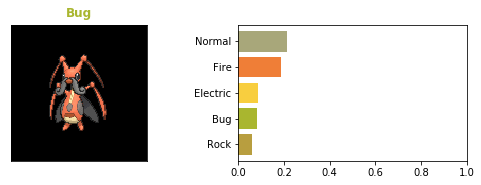

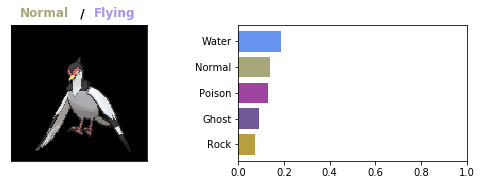

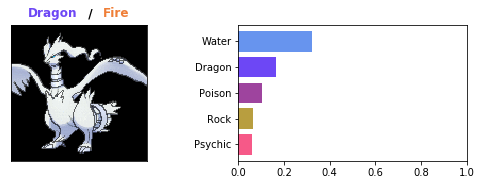

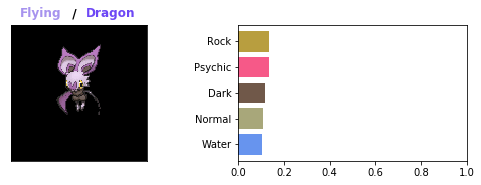

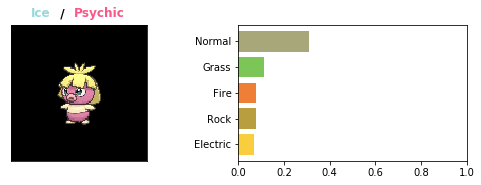

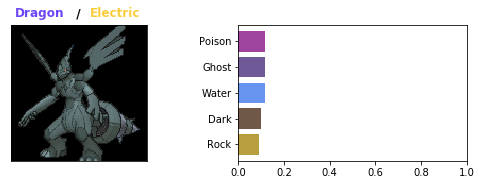

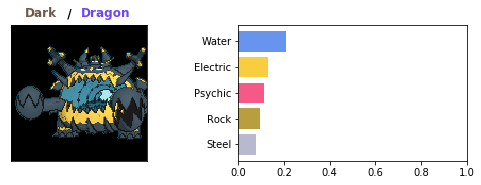

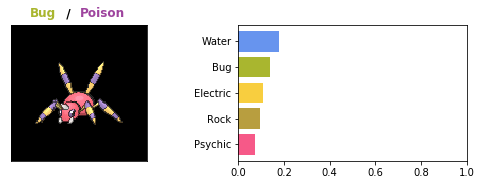

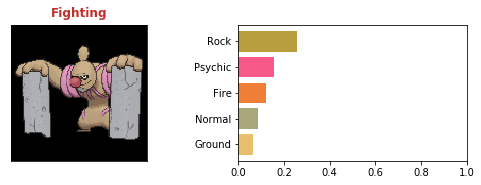

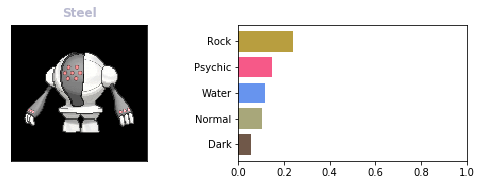

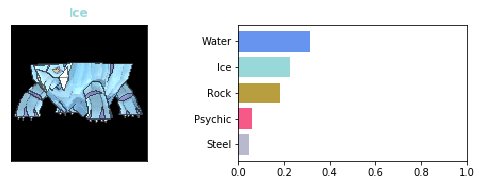

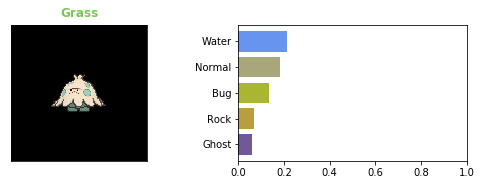

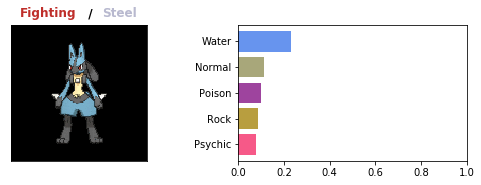

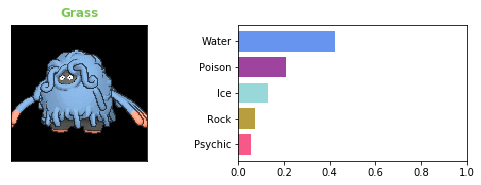

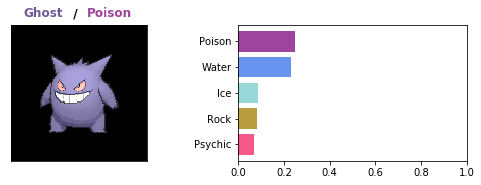

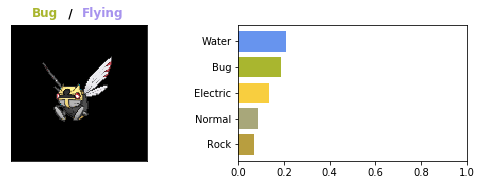

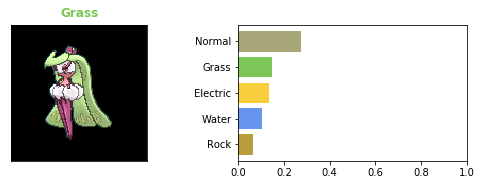

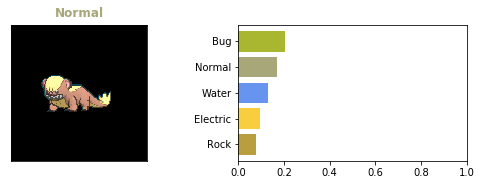

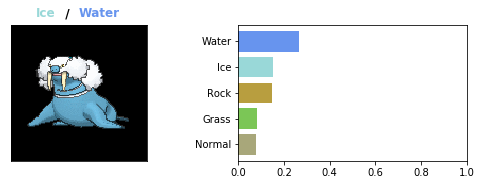

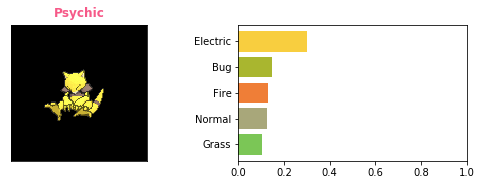

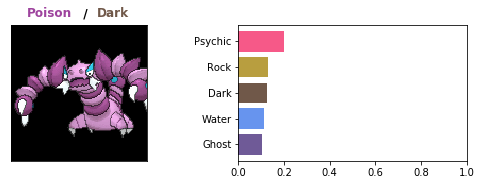

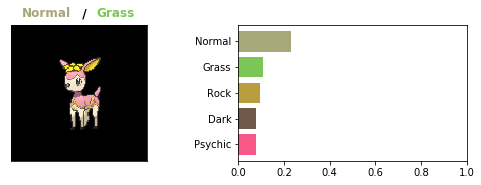

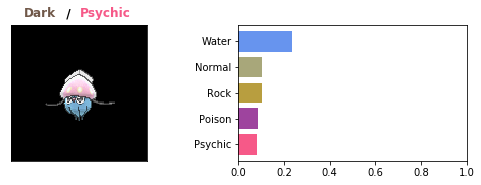

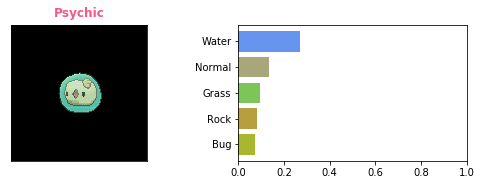

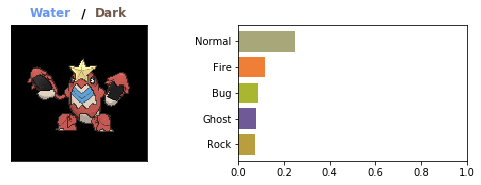

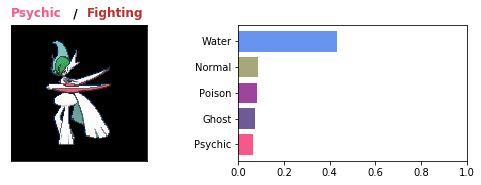

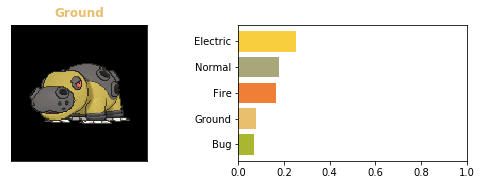

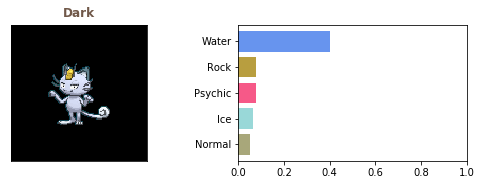

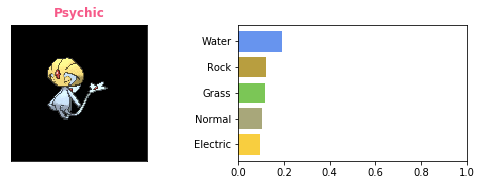

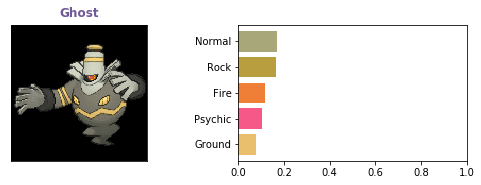

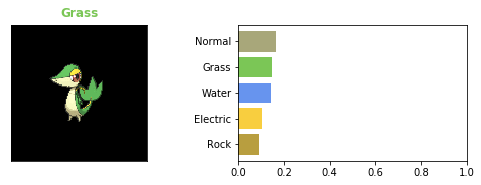

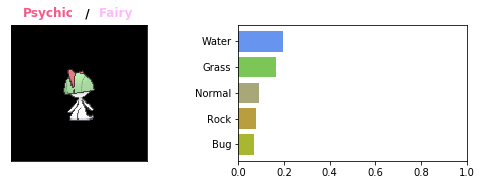

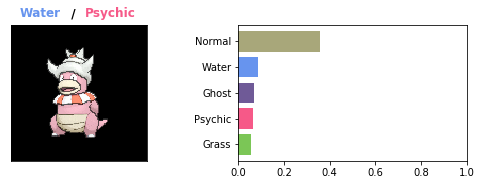

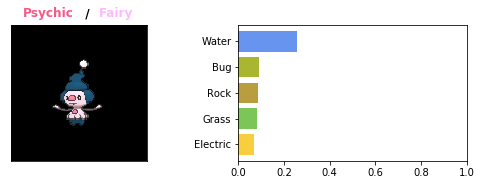

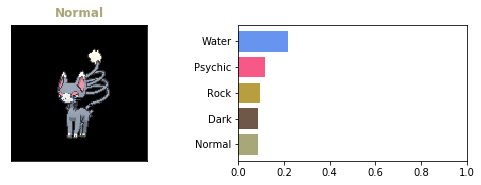

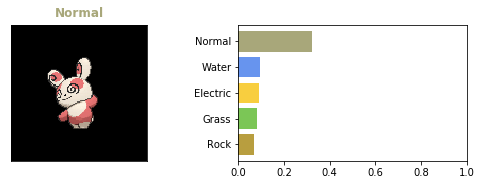

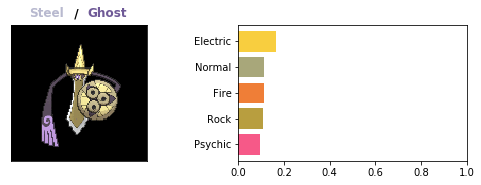

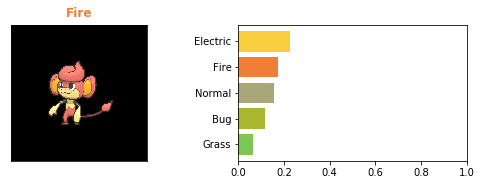

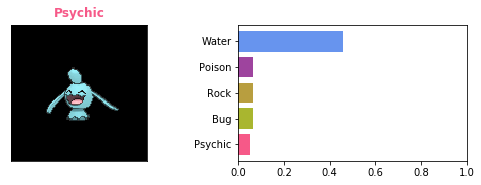

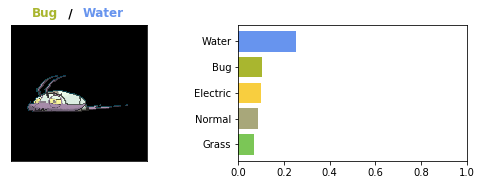

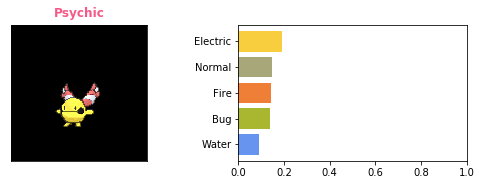

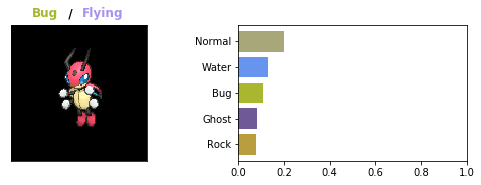

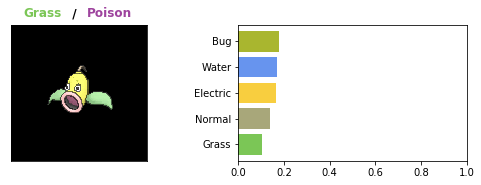

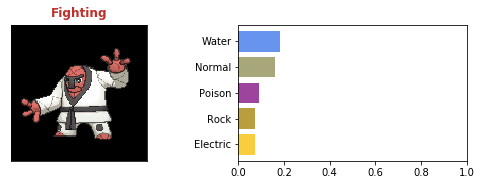

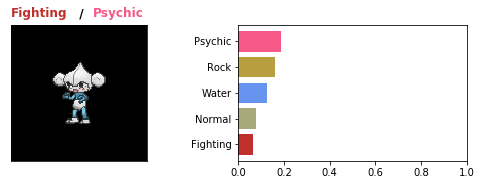

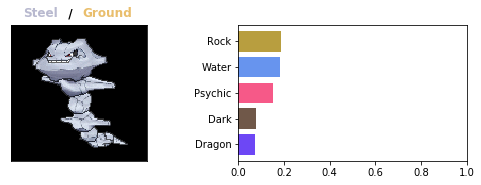

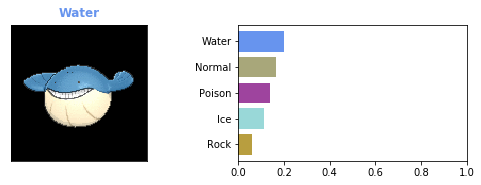

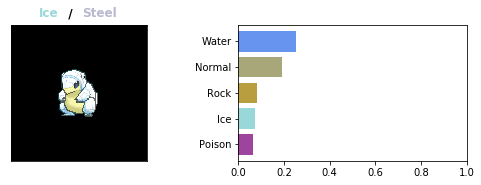

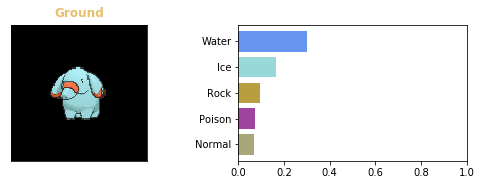

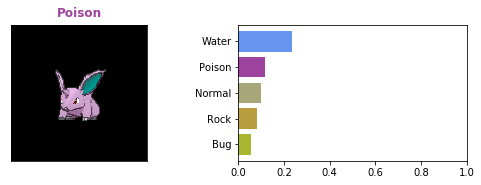

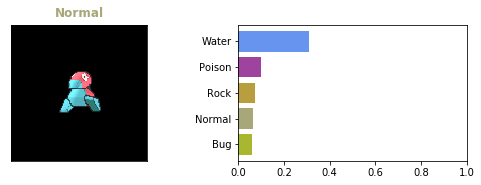

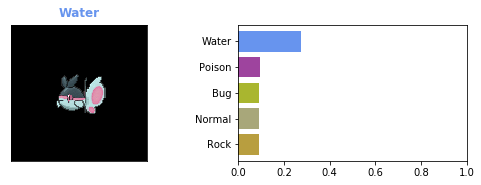

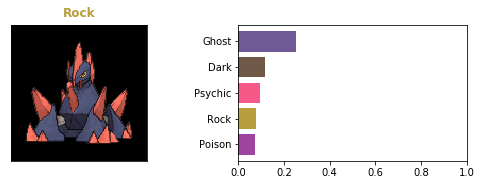

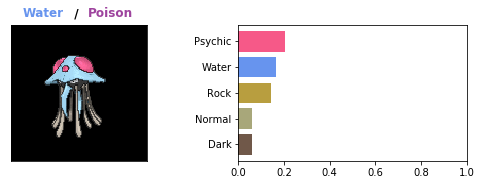

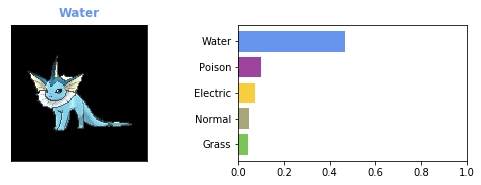

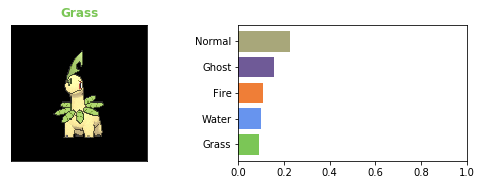

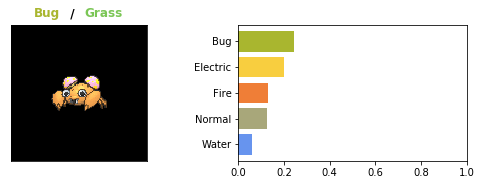

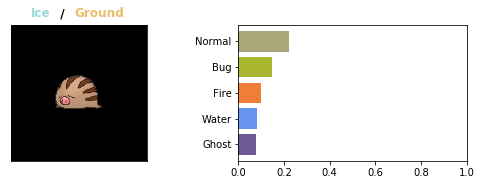

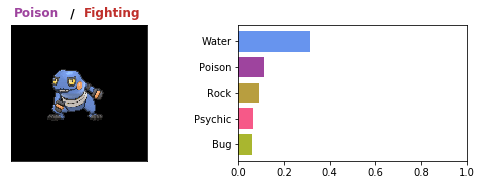

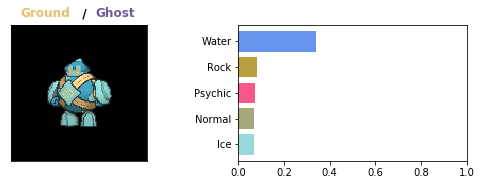

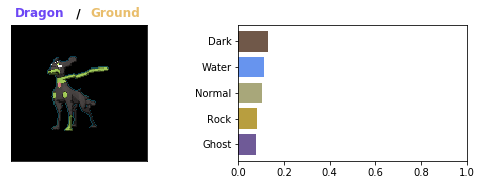

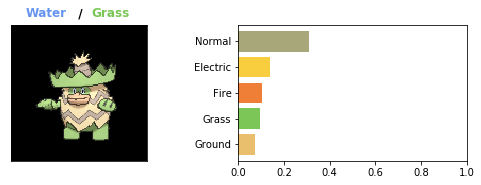

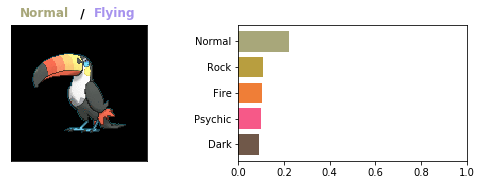

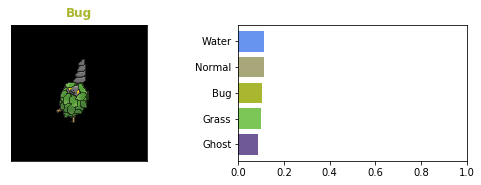

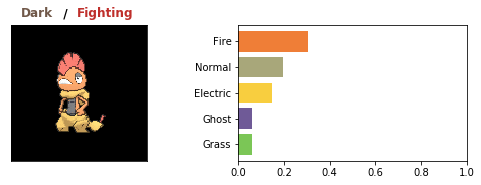

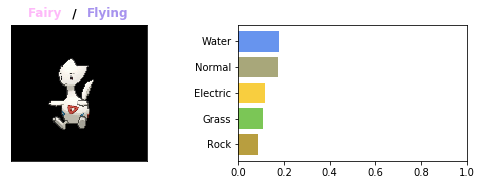

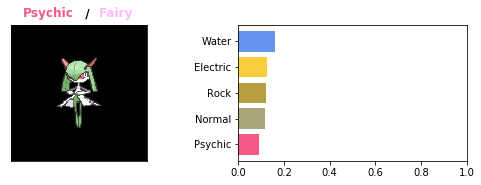

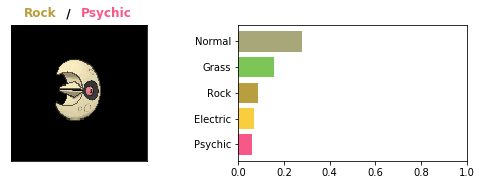

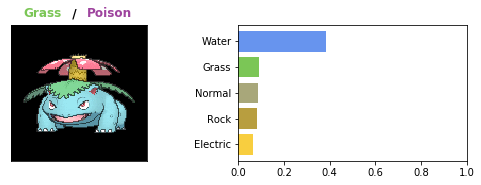

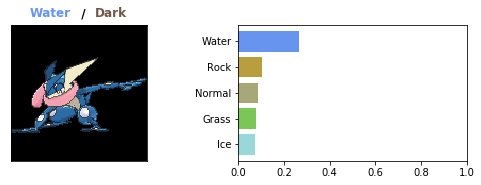

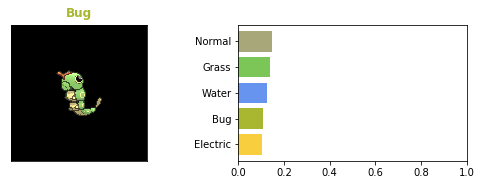

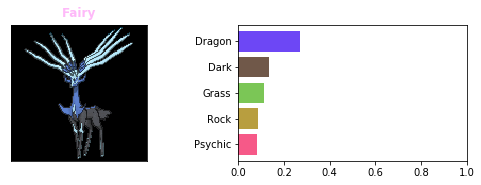

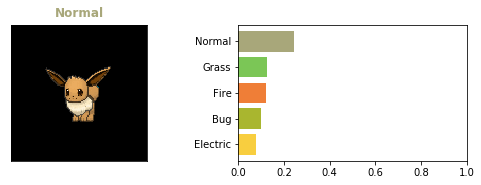

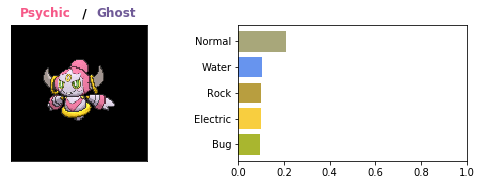

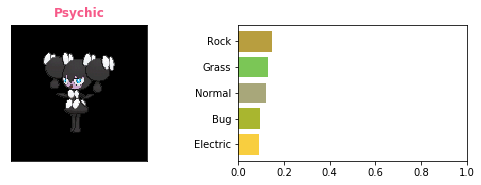

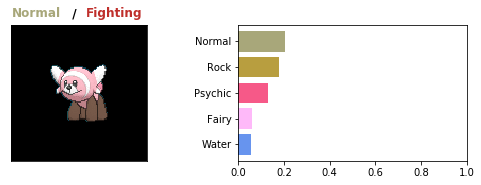

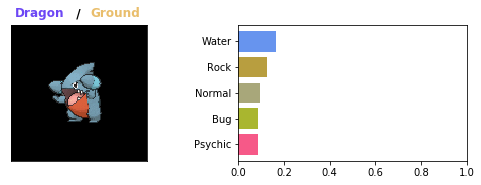

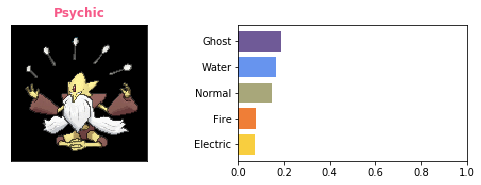

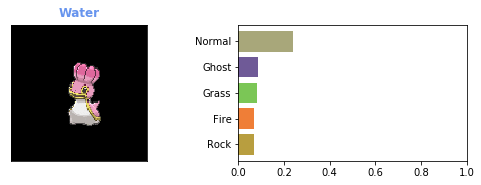

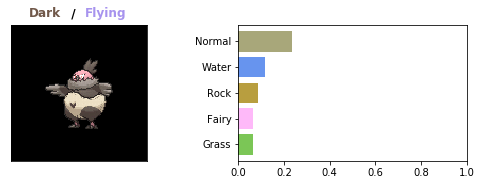

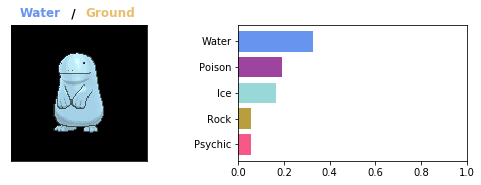

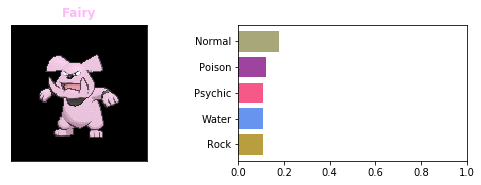

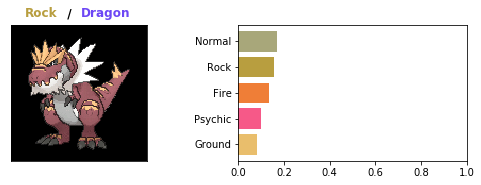

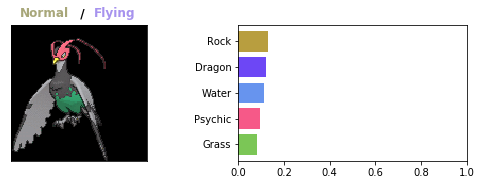

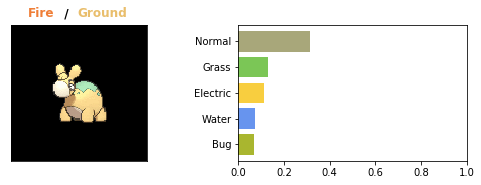

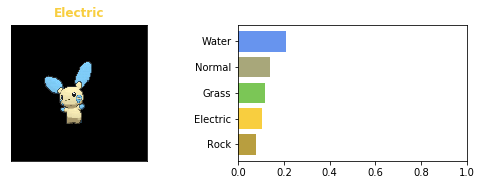

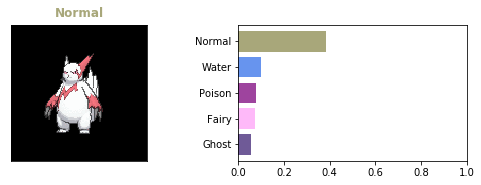

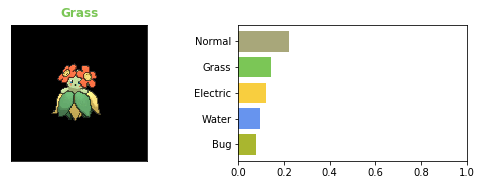

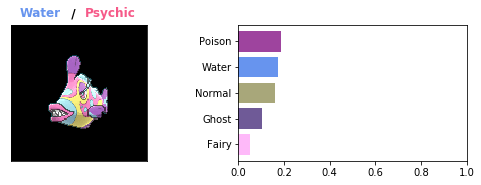

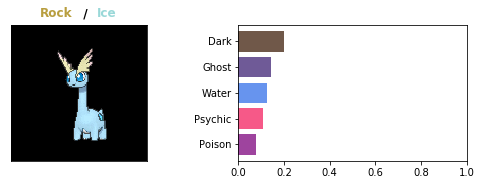

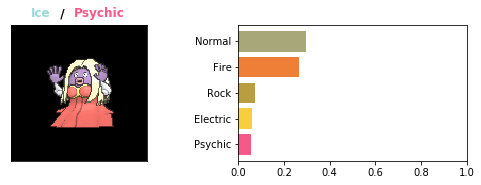

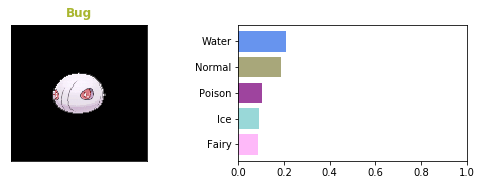

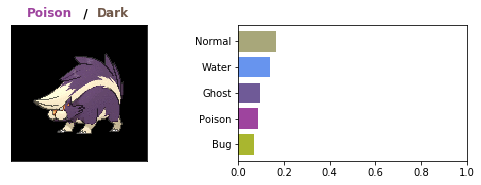

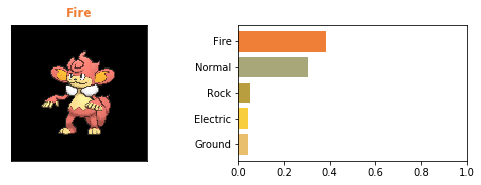

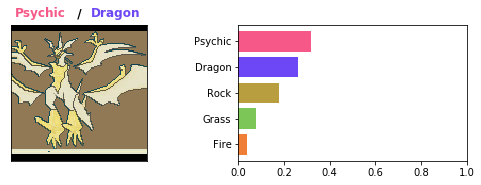

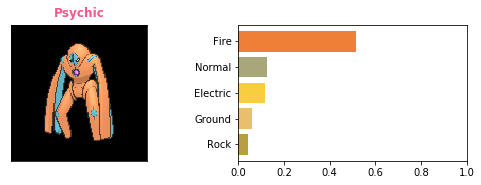

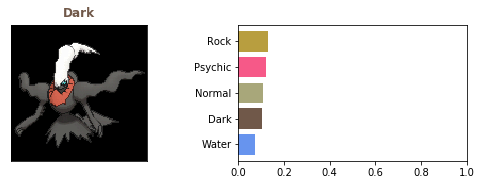

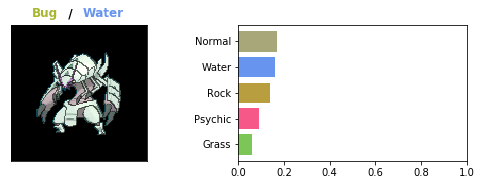

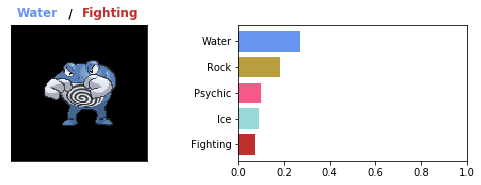

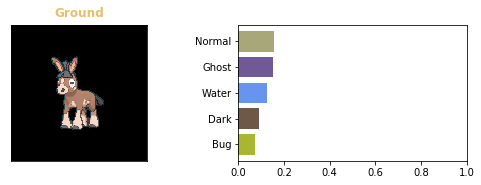

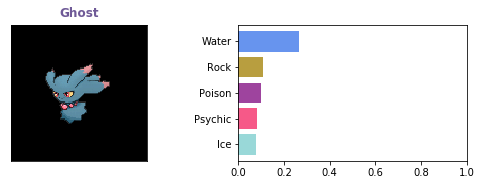

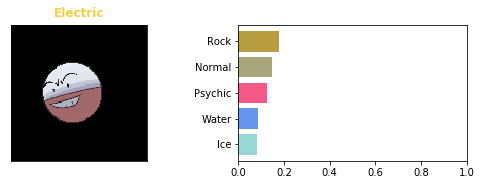

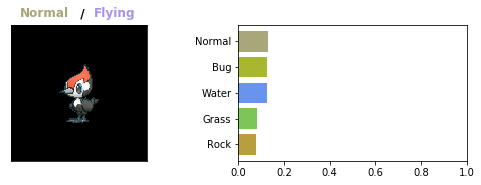

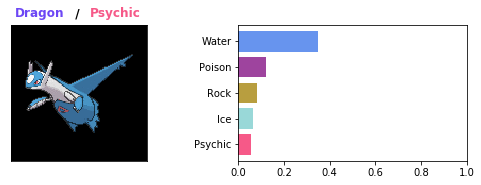

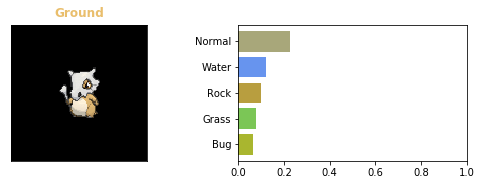

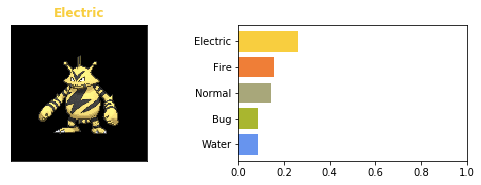

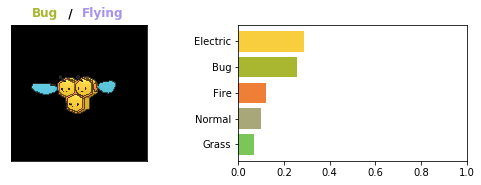

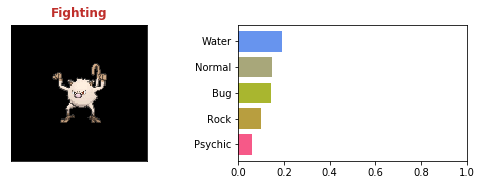

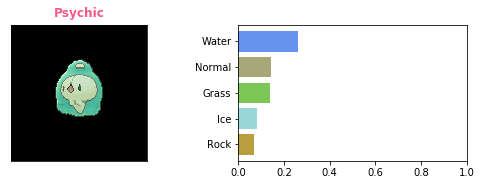

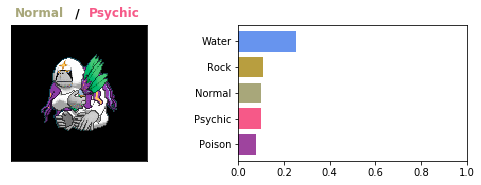

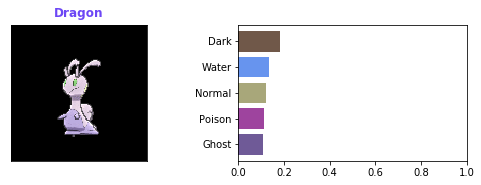

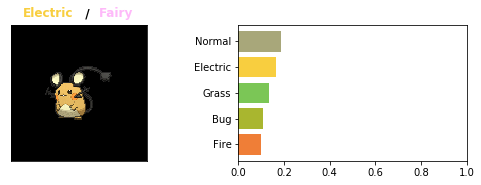

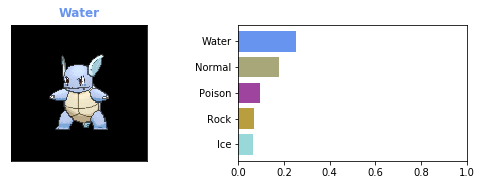

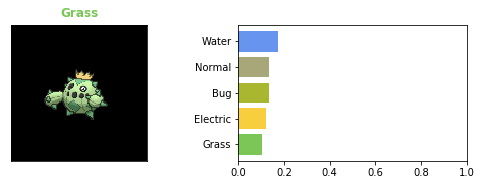

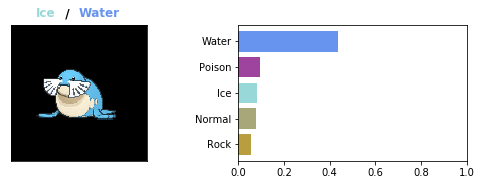

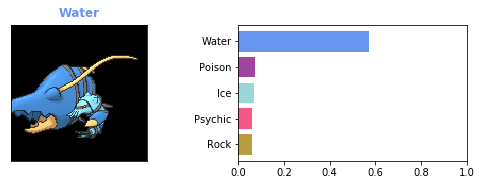

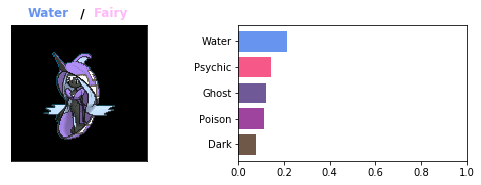

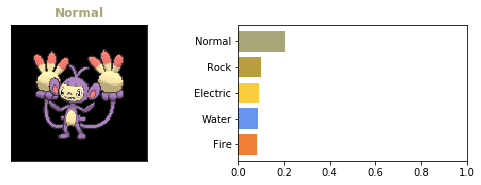

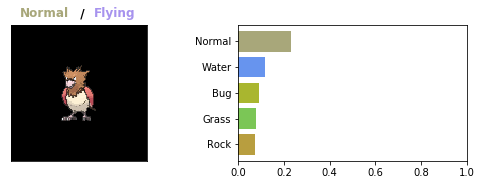

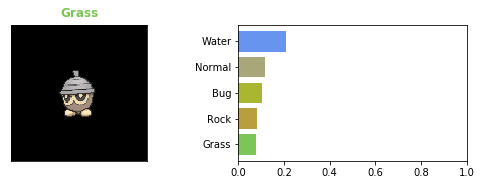

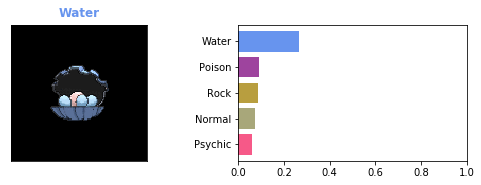

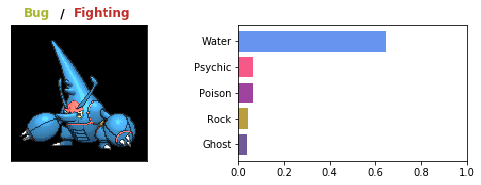

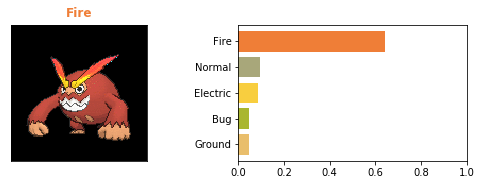

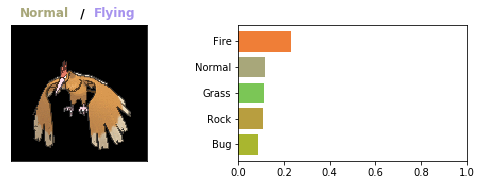

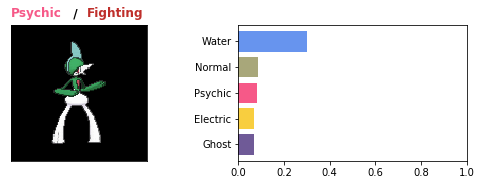

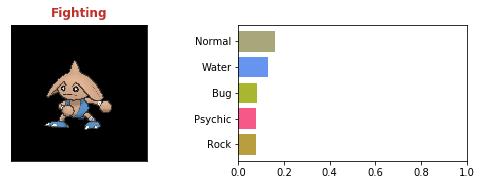

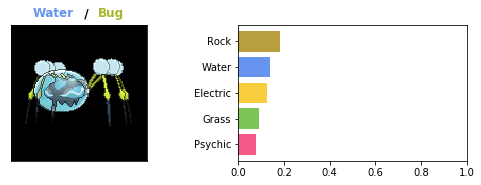

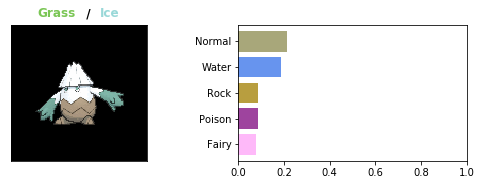

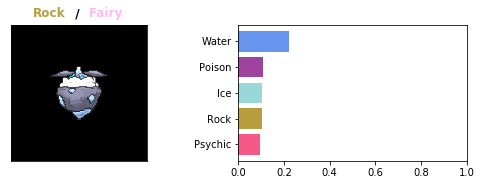

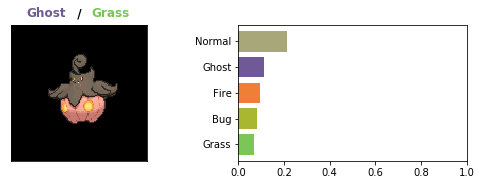

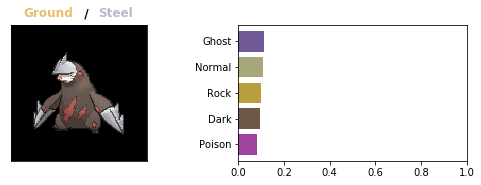

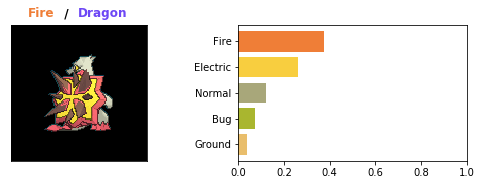

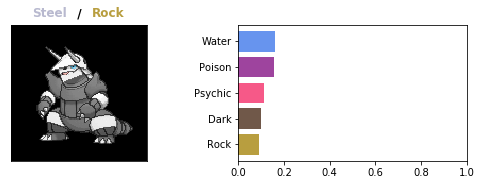

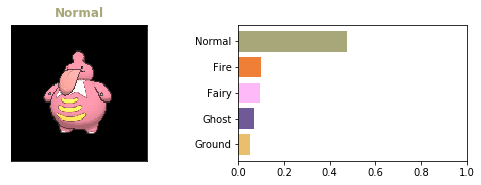

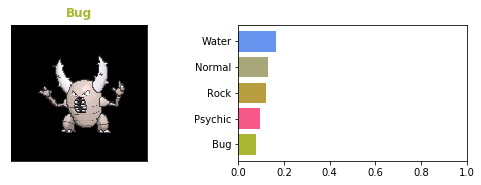

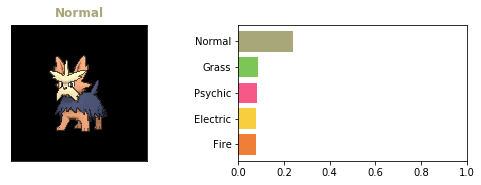

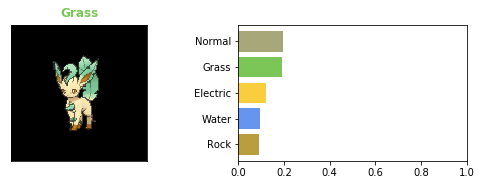

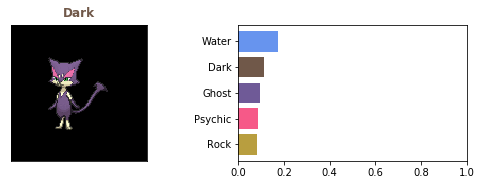

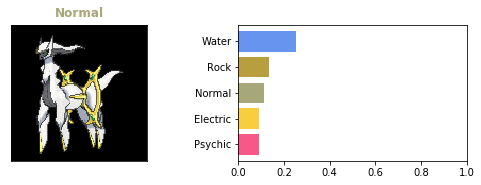

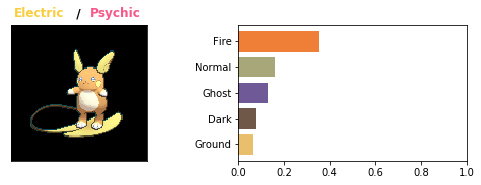

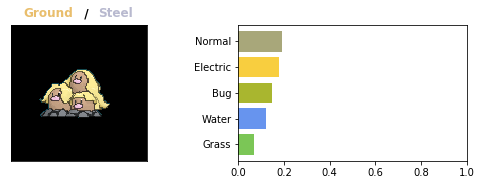

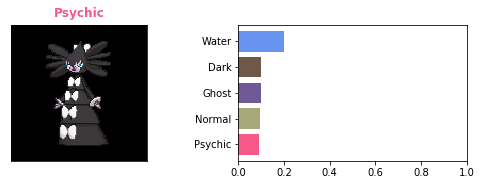

In [66]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Validation predictions")
pp.plotPredictions(x_val_i[start*step:(start+num)*step:step],
                   y_val_m[start*step:(start+num)*step:step],
                   val_avg_scores[start:start+num:1], k=5, y2=y_val_2[start*step:(start+num)*step:step])

Test predictions


/home/shared/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


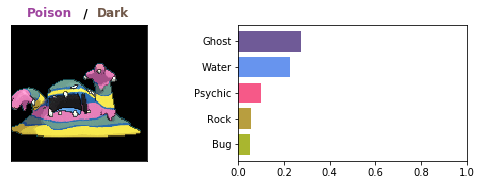

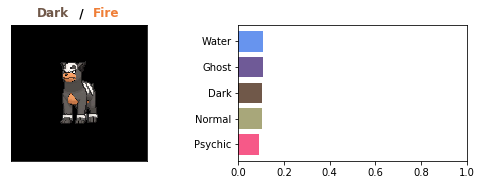

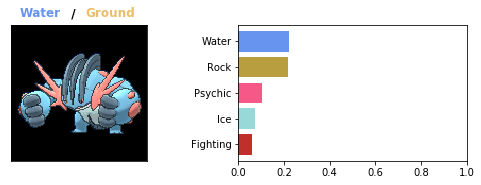

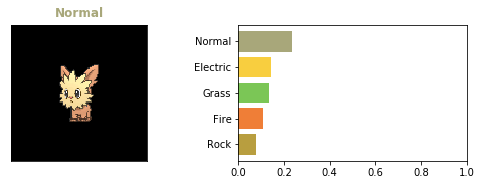

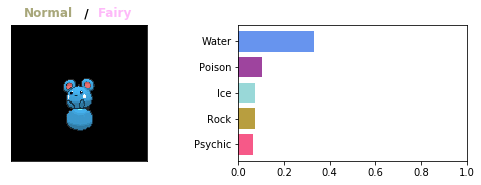

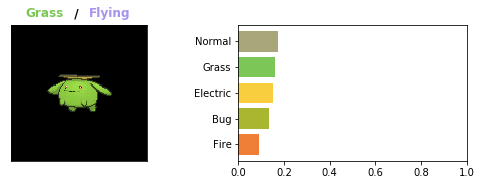

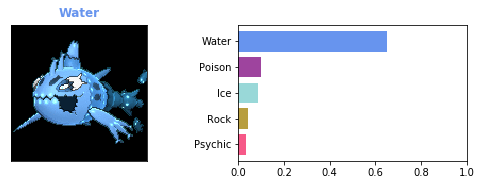

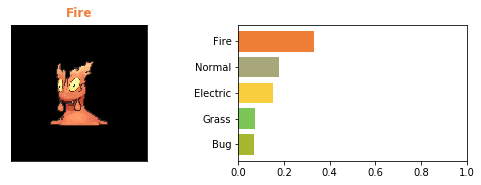

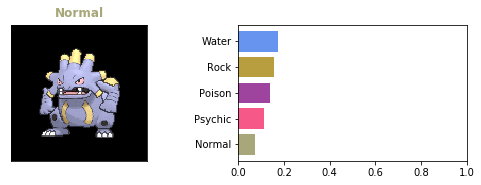

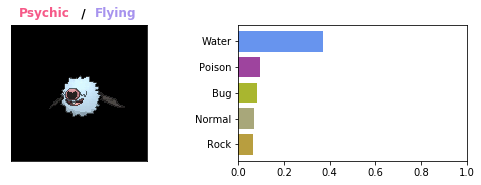

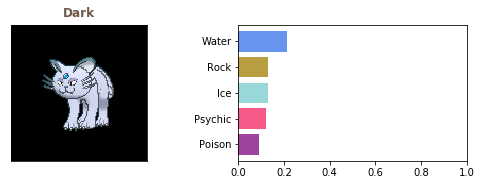

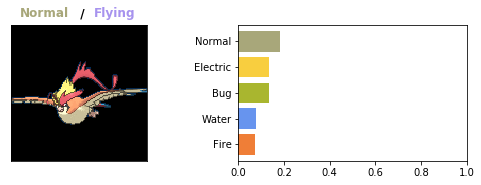

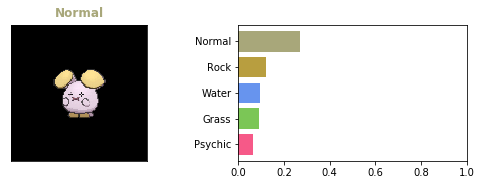

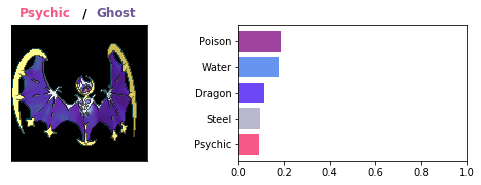

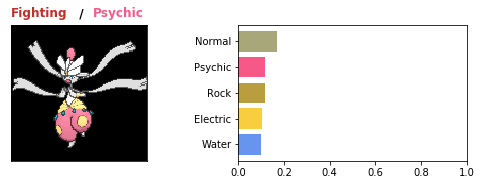

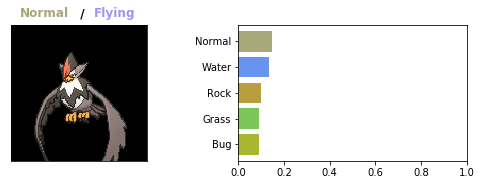

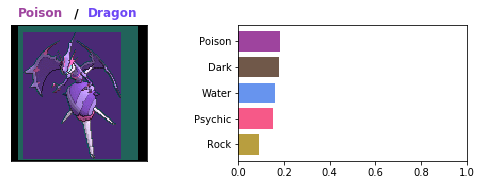

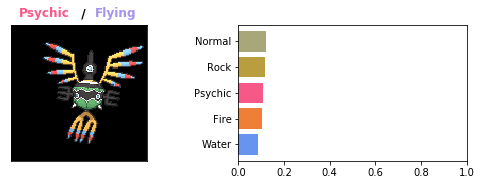

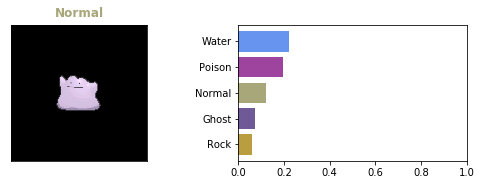

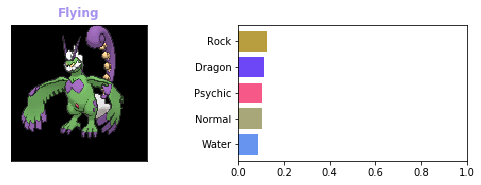

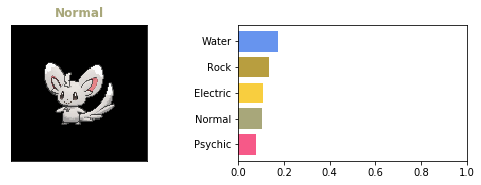

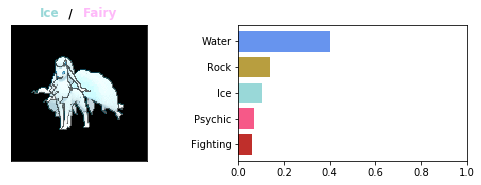

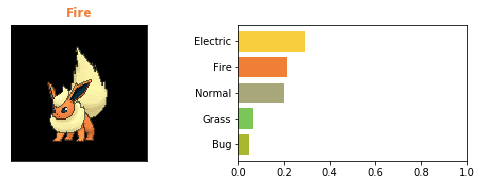

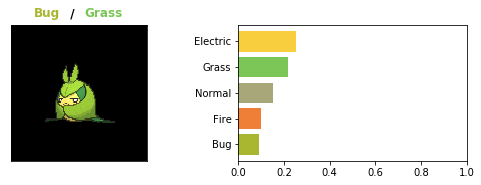

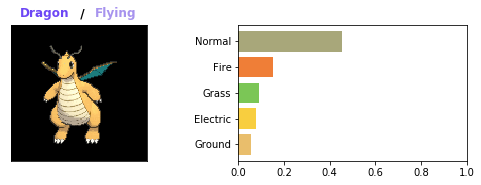

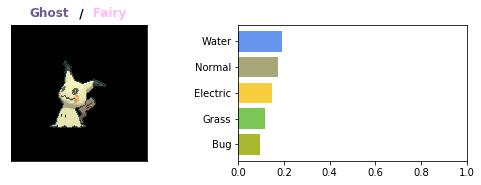

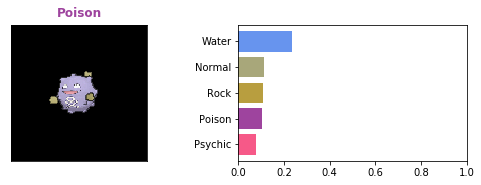

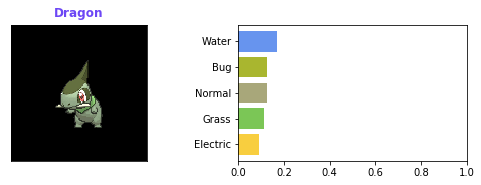

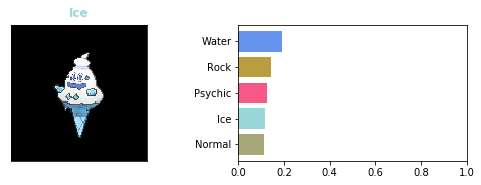

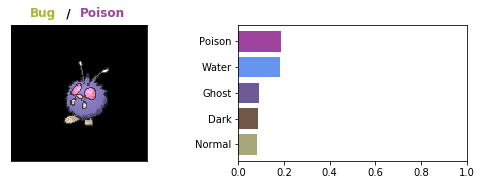

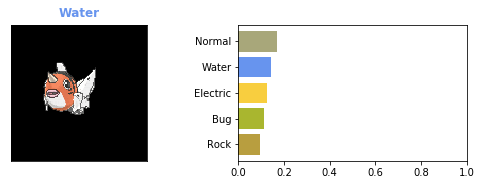

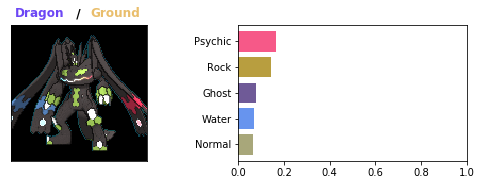

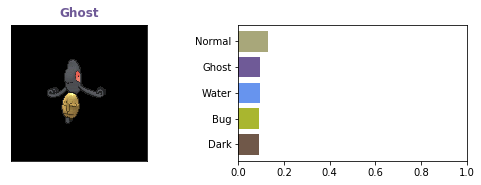

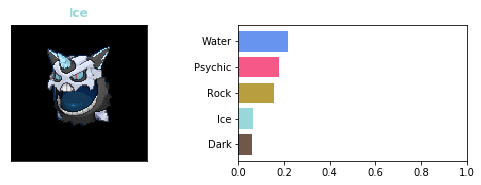

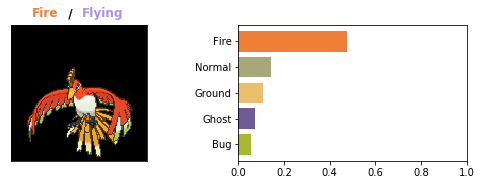

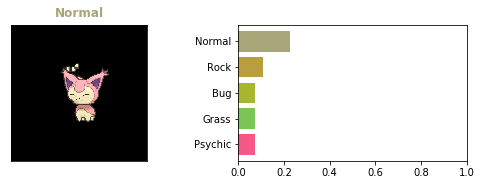

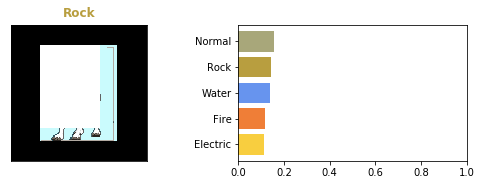

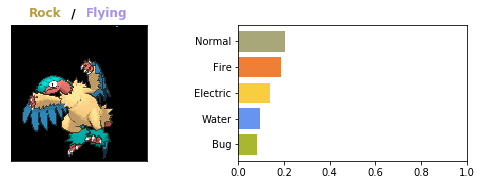

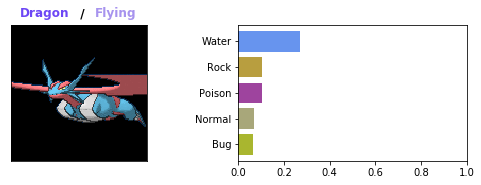

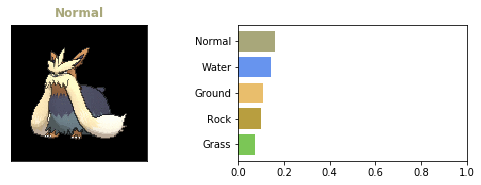

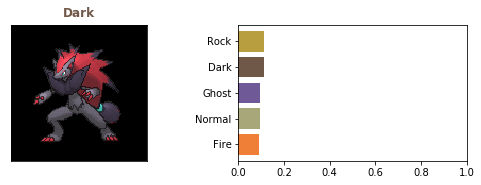

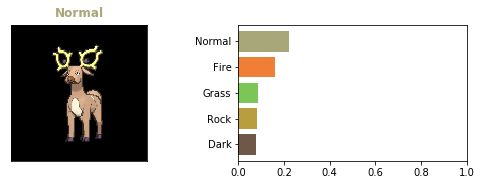

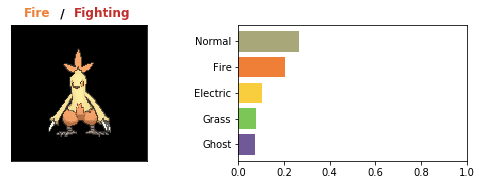

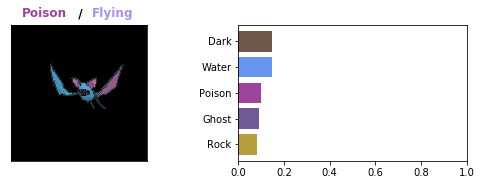

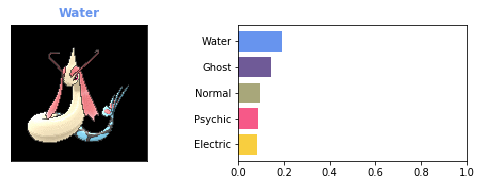

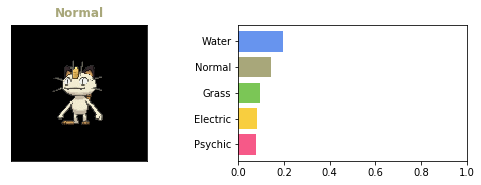

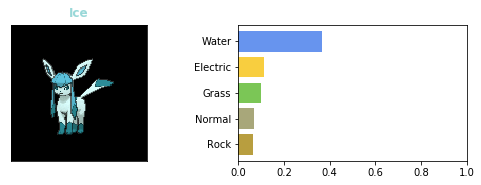

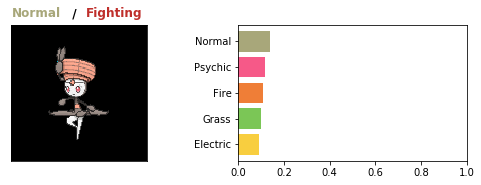

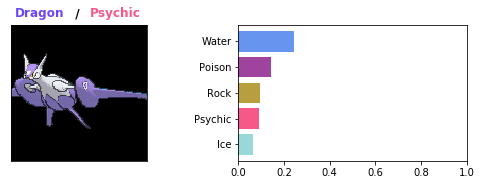

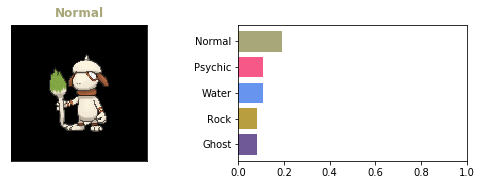

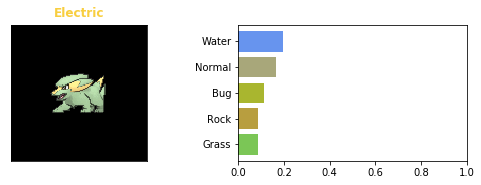

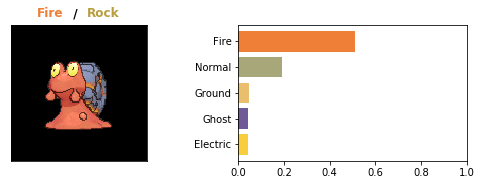

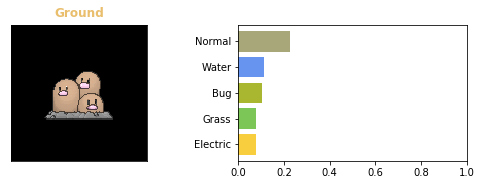

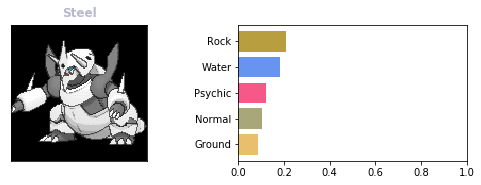

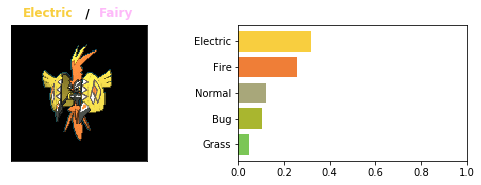

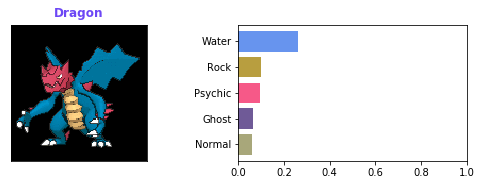

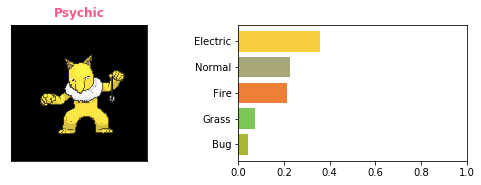

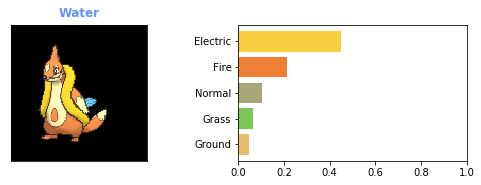

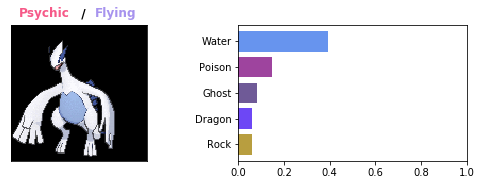

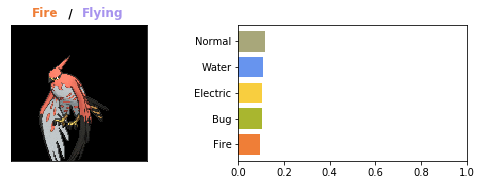

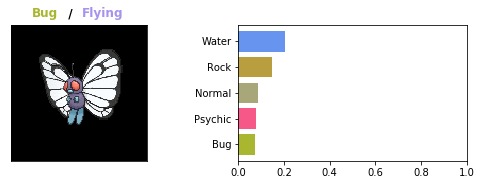

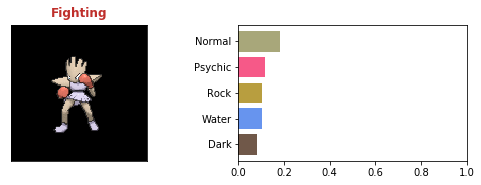

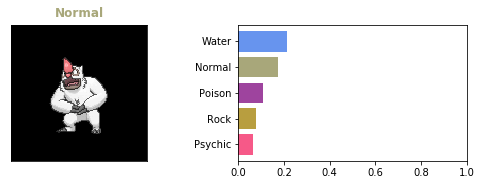

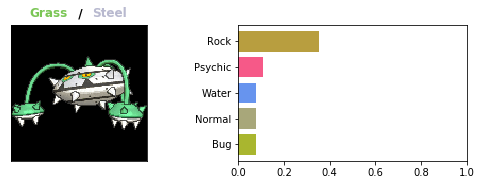

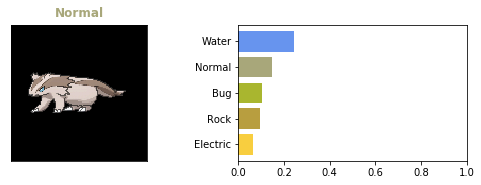

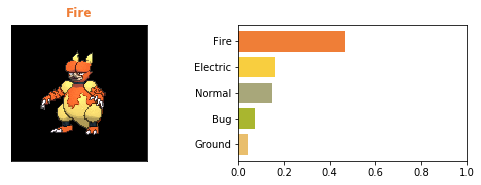

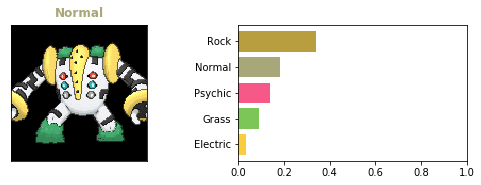

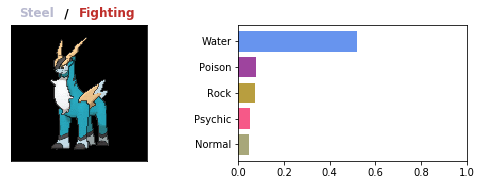

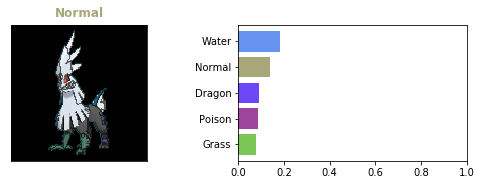

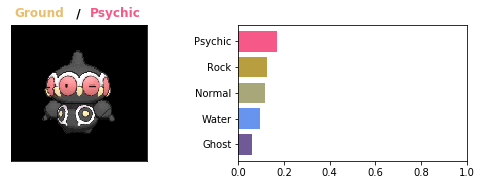

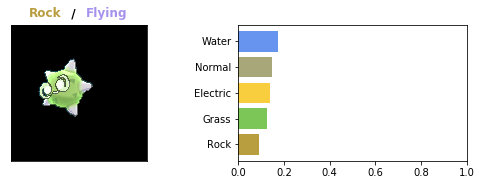

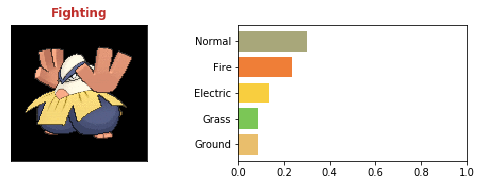

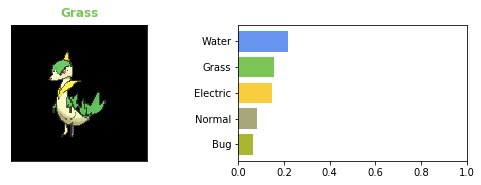

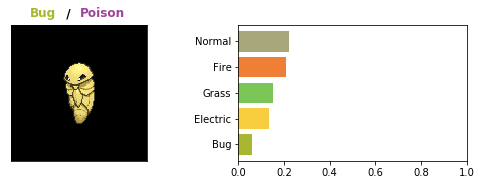

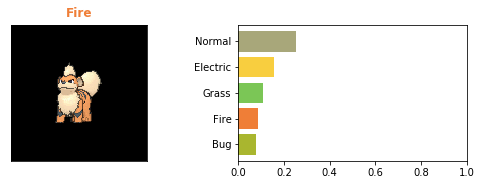

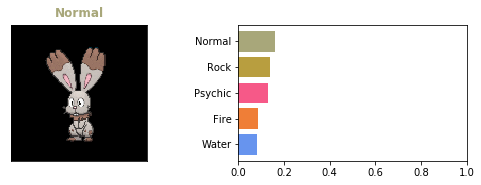

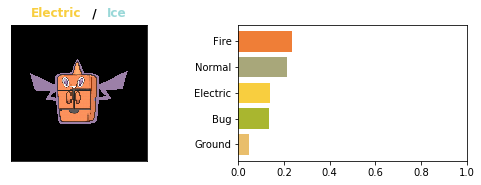

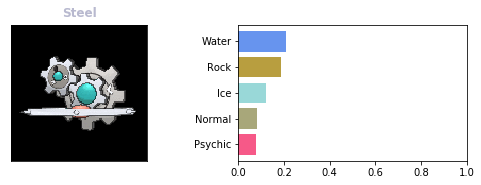

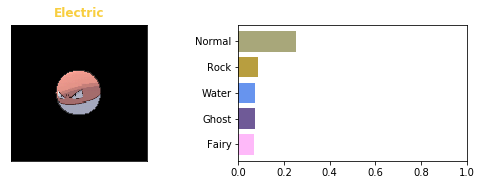

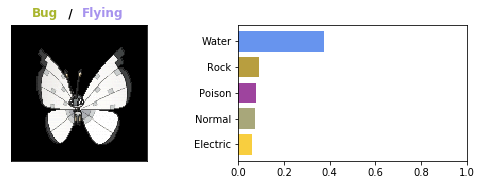

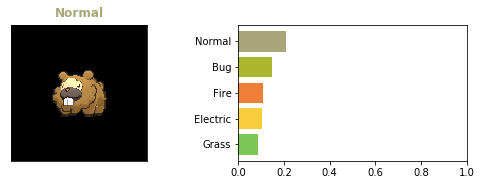

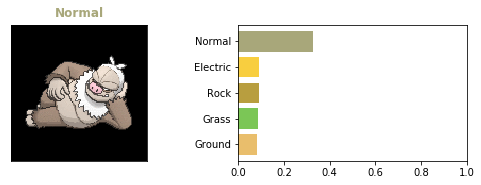

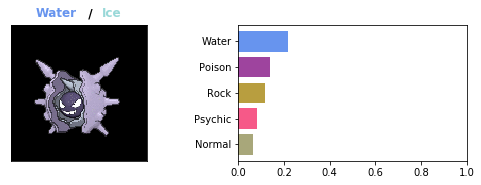

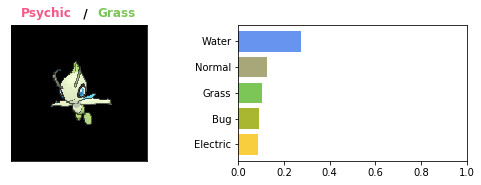

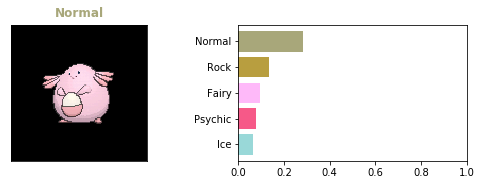

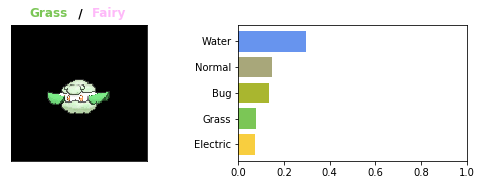

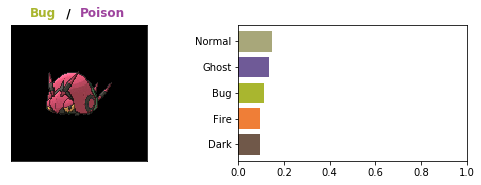

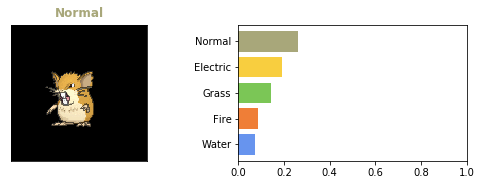

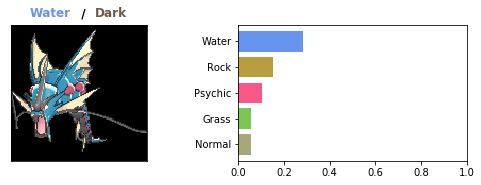

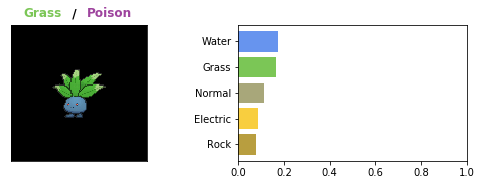

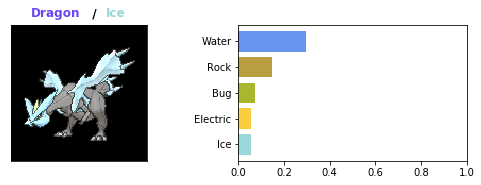

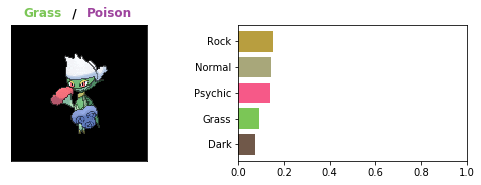

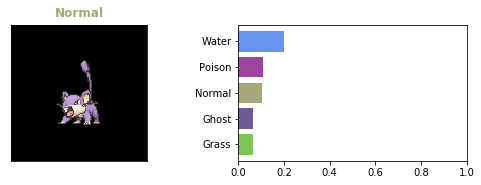

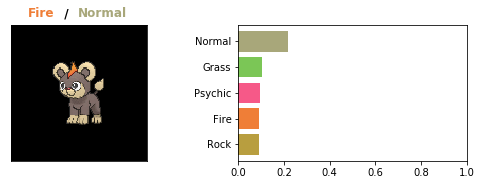

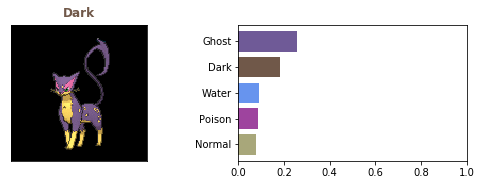

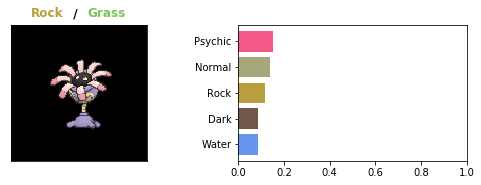

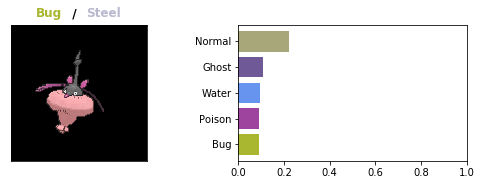

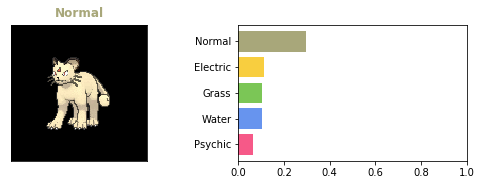

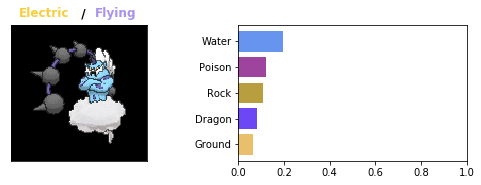

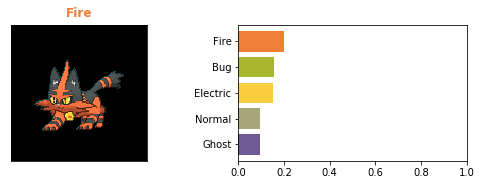

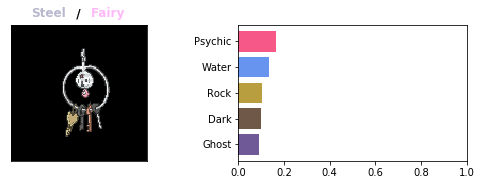

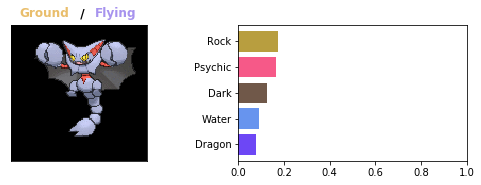

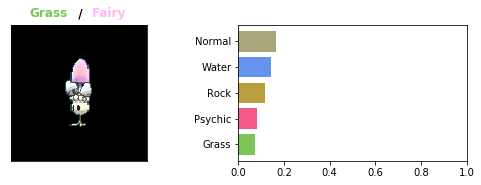

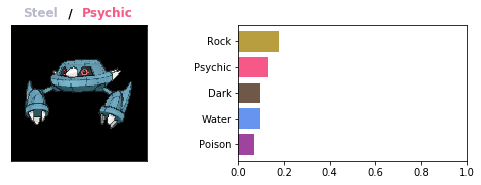

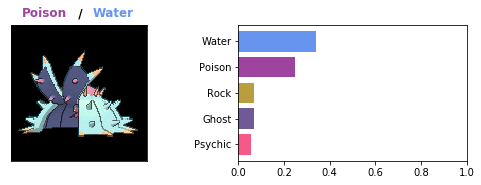

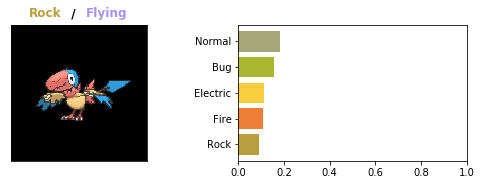

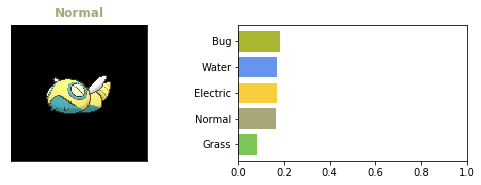

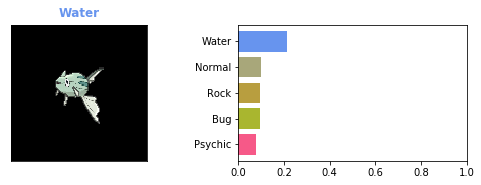

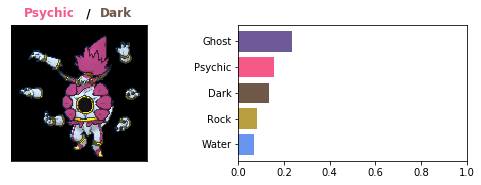

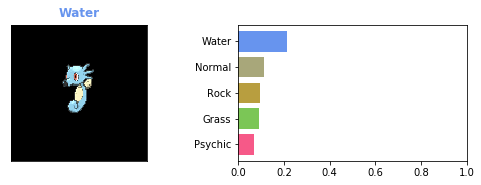

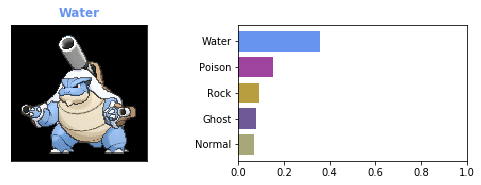

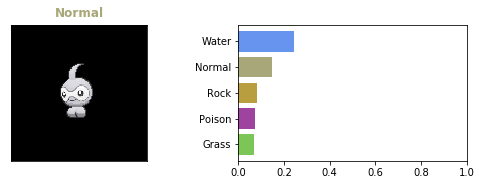

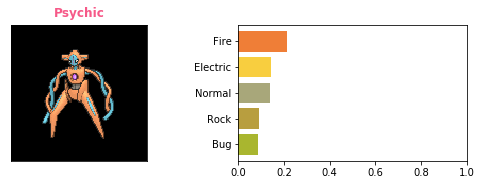

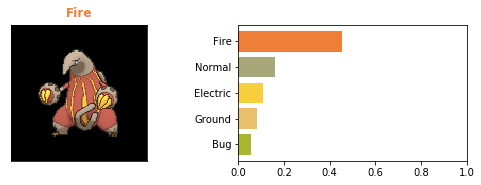

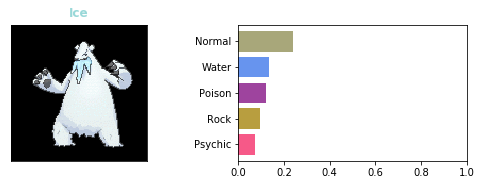

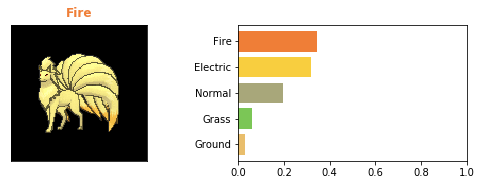

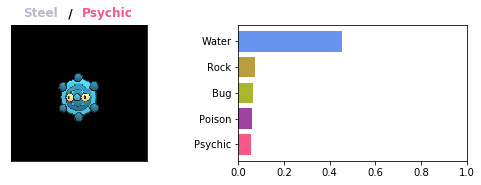

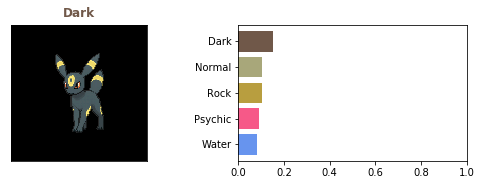

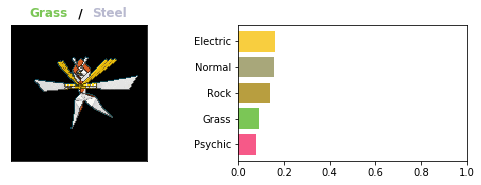

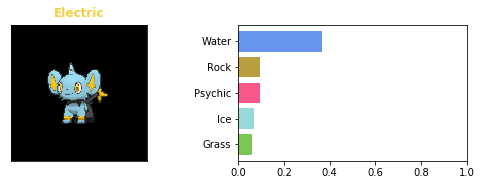

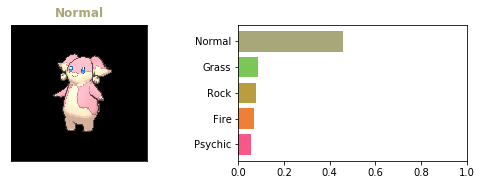

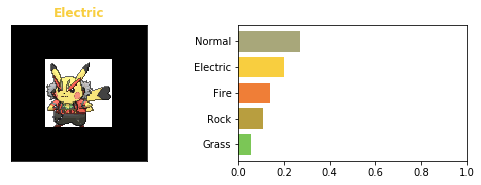

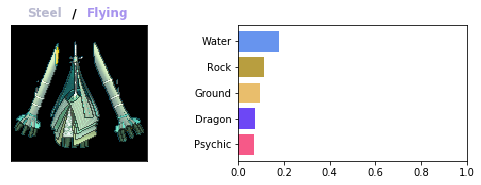

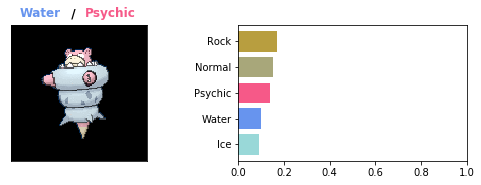

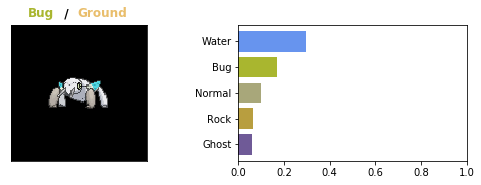

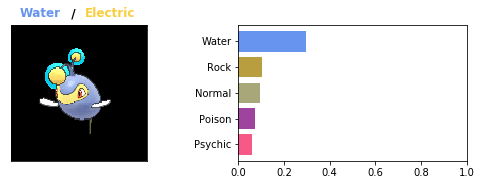

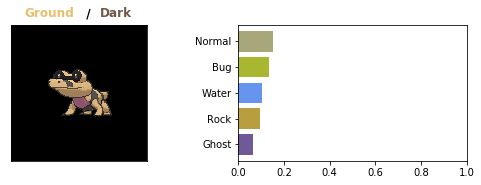

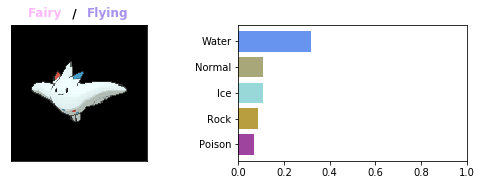

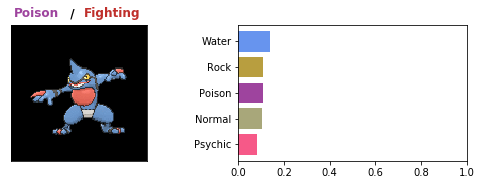

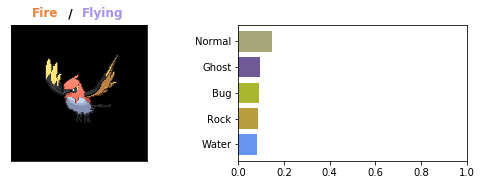

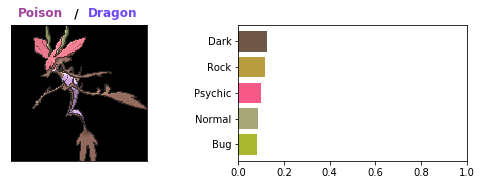

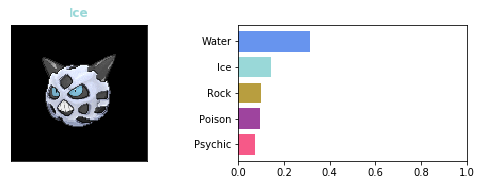

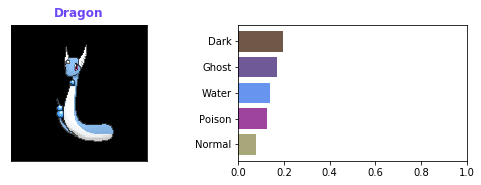

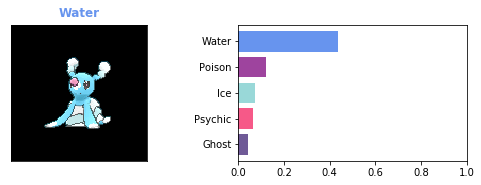

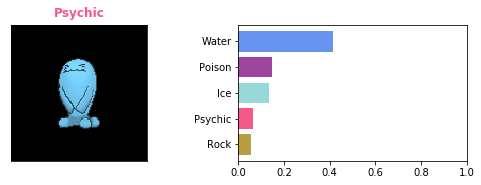

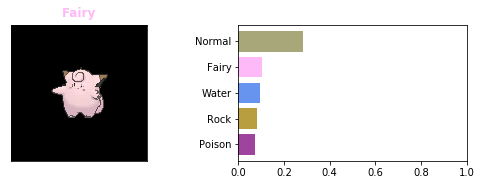

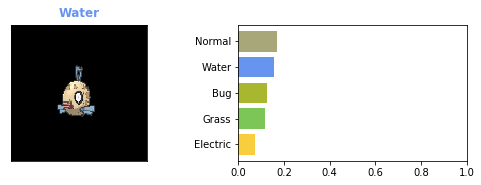

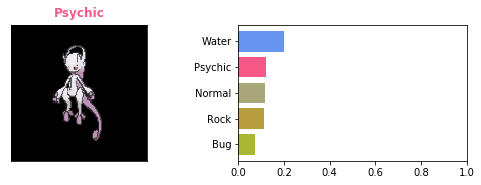

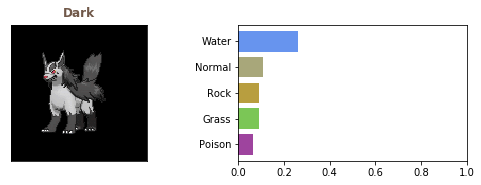

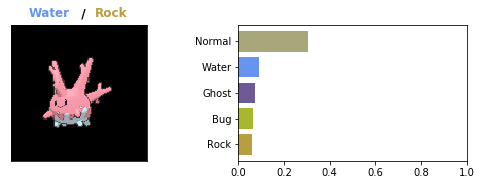

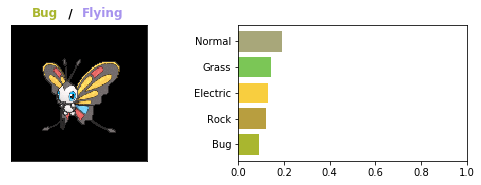

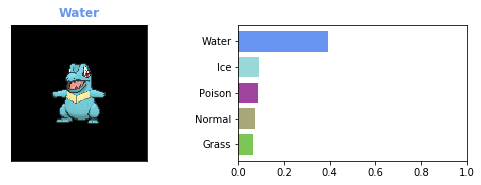

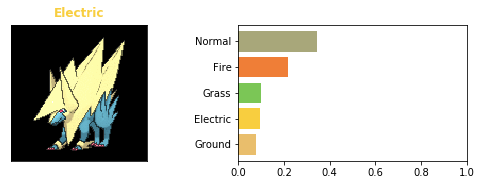

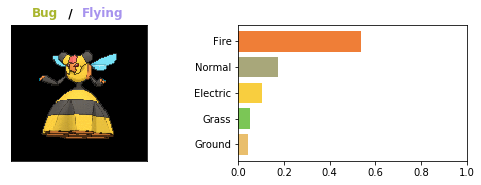

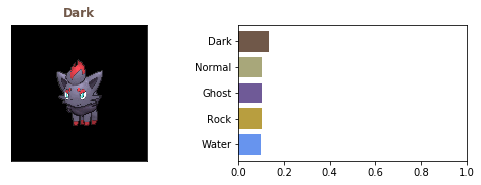

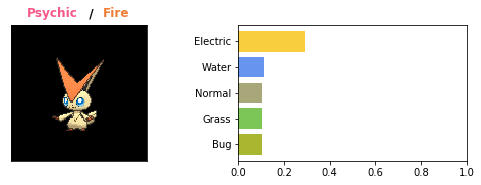

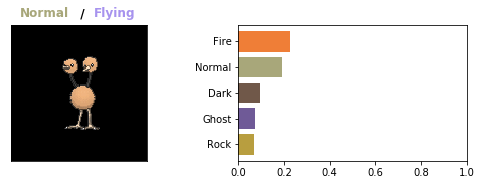

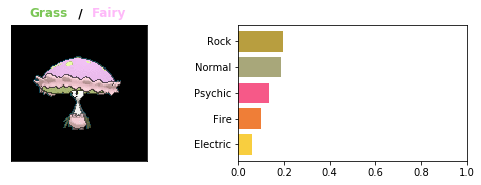

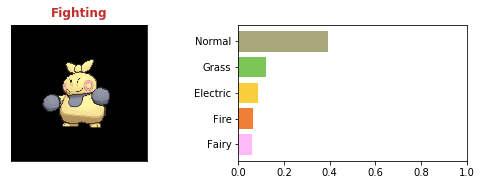

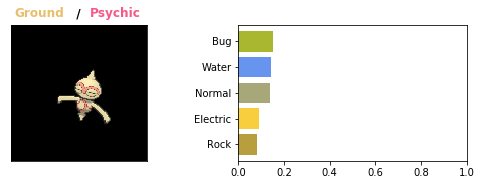

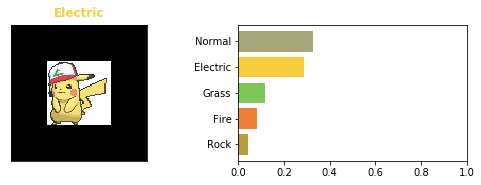

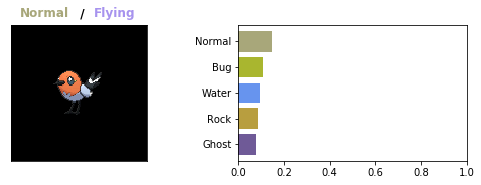

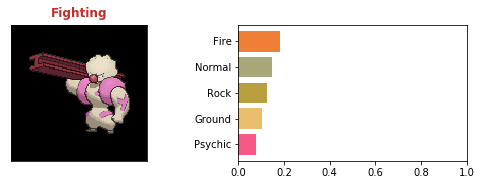

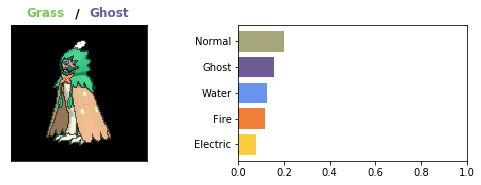

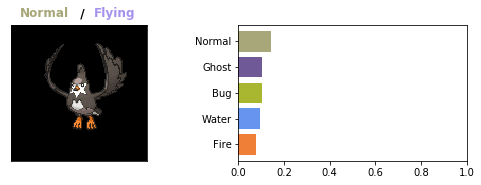

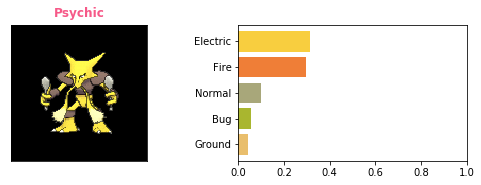

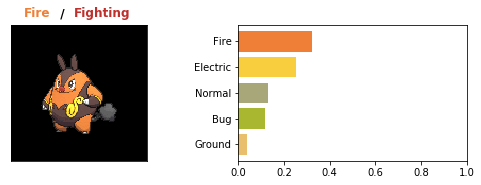

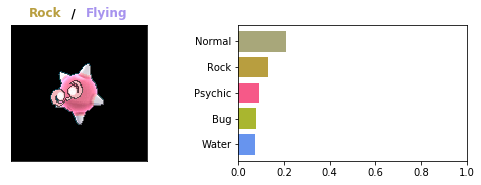

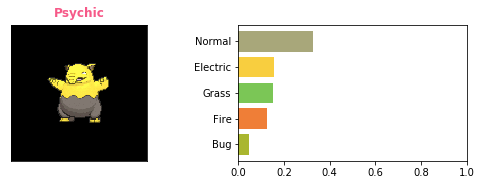

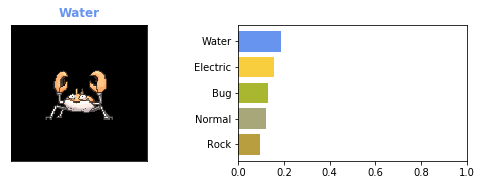

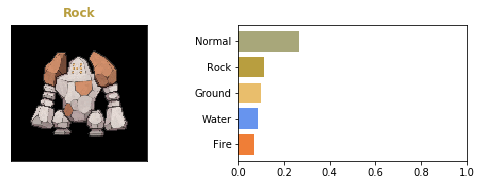

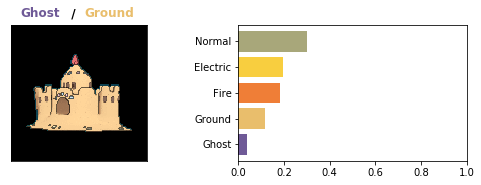

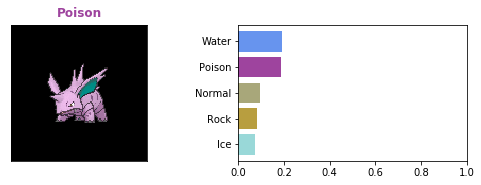

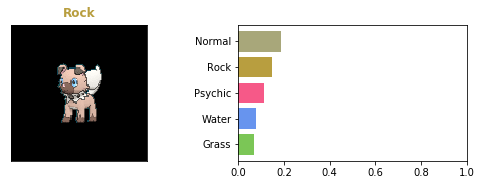

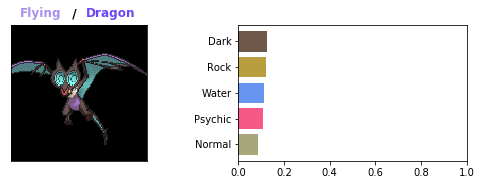

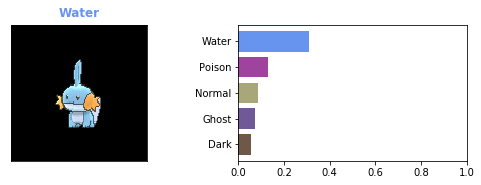

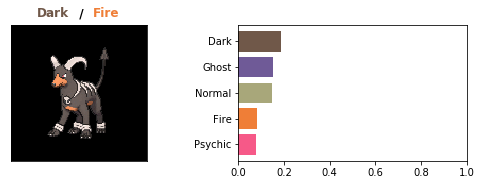

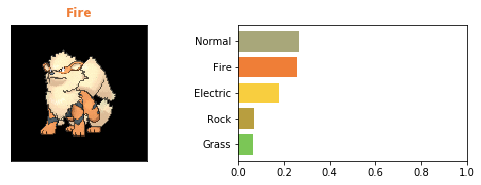

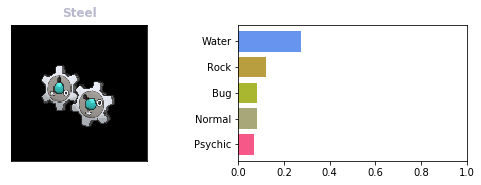

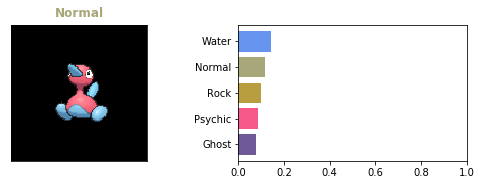

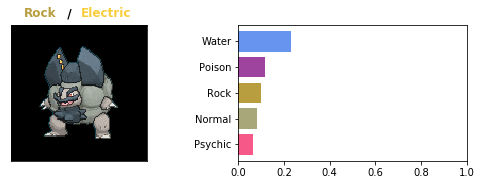

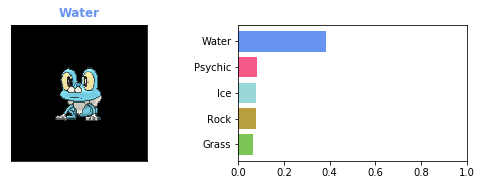

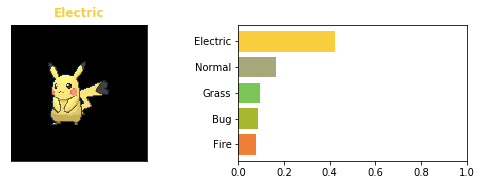

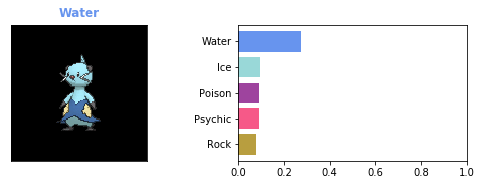

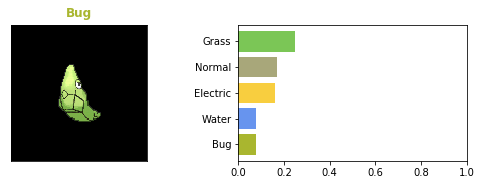

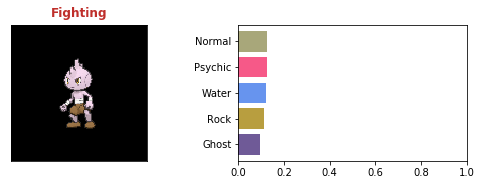

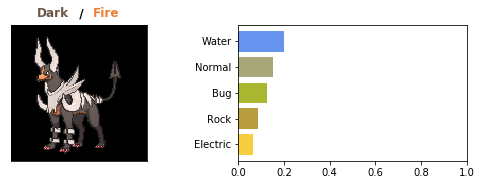

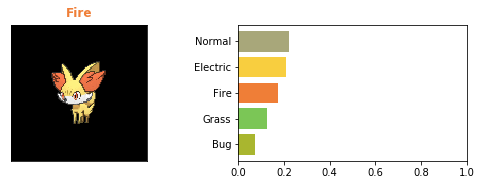

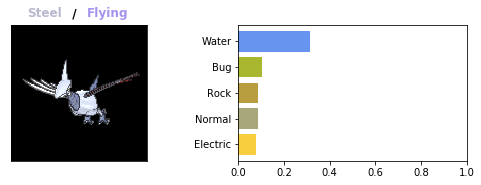

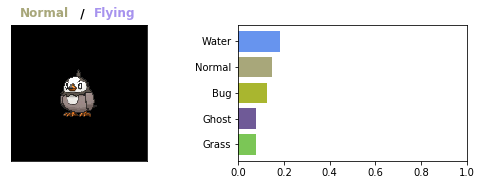

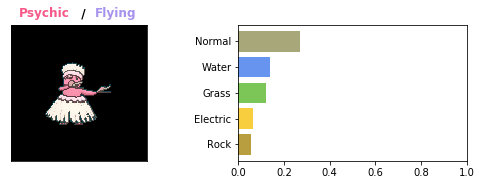

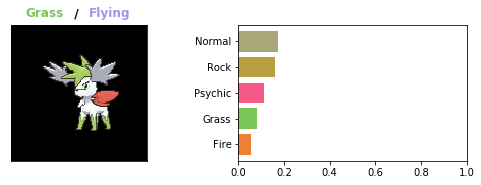

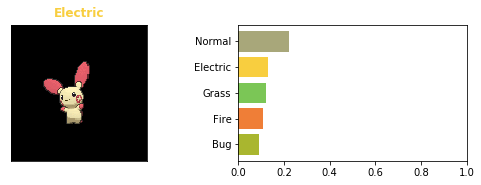

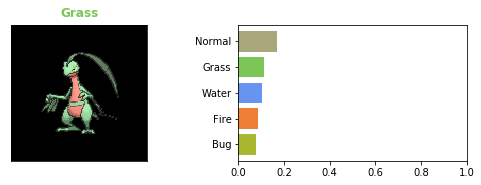

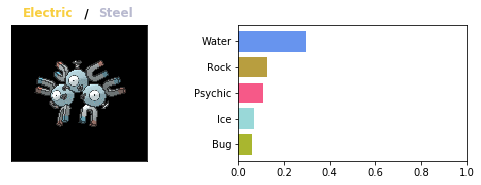

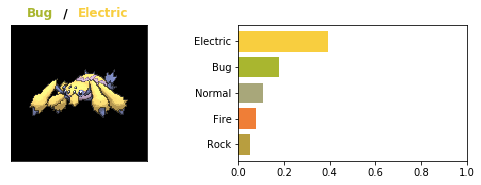

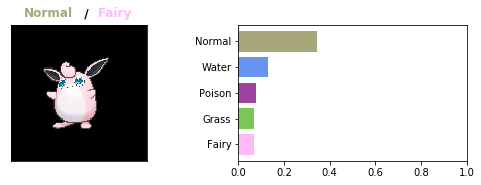

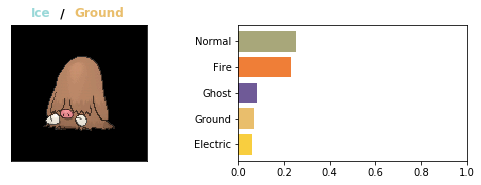

In [67]:
start = 0  # start index
num = 200    # number of images to display
step = 10  # number of frames / pokemon animation

print("Test predictions")
pp.plotPredictions(x_test_i[start*step:(start+num)*step:step],
                   y_test_m[start*step:(start+num)*step:step],
                   test_avg_scores[start:start+num:1], k=5, y2=y_test_2[start*step:(start+num)*step:step])